## Парсинг

In [1]:
!pip install requests

In [2]:
!pip install fake_useragent

In [3]:
import requests 
from fake_useragent import UserAgent

# визуализация циклов
from tqdm.notebook import tqdm

import time
header = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'
url = 'https://fbref.com'
response = requests.get(url, headers = {'UserAgent': UserAgent().chrome})
response

<Response [200]>

In [4]:
response.content[:1000]

b'    \n      \n<!DOCTYPE html>\n<html data-version="klecko-" data-root="/home/fb/build" lang="en" class="no-js" >\n<head id="suppress_all_ads">\n    <meta charset="utf-8">\n    <meta http-equiv="x-ua-compatible" content="ie=edge">\n    <meta name="viewport" content="width=device-width, initial-scale=1.0, maximum-scale=2.0" />\n    <link rel="dns-prefetch" href="https://cdn.ssref.net/req/202305081" />\n<!-- Quantcast Choice. Consent Manager Tag v2.0 (for TCF 2.0) -->\n<script type="text/javascript" async=true>\n    (function() {\n\tvar host = window.location.hostname;\n\tvar element = document.createElement(\'script\');\n\tvar firstScript = document.getElementsByTagName(\'script\')[0];\n\tvar url = \'https://cmp.quantcast.com\'\n\t    .concat(\'/choice/\', \'XwNYEpNeFfhfr\', \'/\', host, \n\t\t    \'/choice.js?tag_version=V2\');\n\tvar uspTries = 0;\n\tvar uspTriesLimit = 3;\n\telement.async = true;\n\telement.type = \'text/javascript\';\n\telement.src = url;\n\t\n\tfirstScript.parentN

In [5]:
from bs4 import BeautifulSoup

# распарсили страничку в дерево 
tree = BeautifulSoup(response.content, 'html.parser')

In [6]:
ex = tree.find('li', {'id': 'header_comps'})
url_tail = ex.a.get('href')
full_url = url + url_tail
full_url

'https://fbref.com/en/comps/'

In [7]:
new_response = requests.get(full_url)
tree = BeautifulSoup(new_response.content, 'html.parser')

In [8]:
new_response.content[:200]

b'    \n      \n<!DOCTYPE html>\n<html data-version="klecko-" data-root="/home/fb/deploy/www/base" lang="en" class="no-js" >\n<head>\n    <meta charset="utf-8">\n    <meta http-equiv="x-ua-compatible" content'

In [9]:
big_five = tree.find('div', {'id': 'all_comps_club'})
big_five_new = big_five.tbody.find_all('tr')

In [10]:
leagues_urls = []

for i in range(5):
    time.sleep(3.3)
    leagues_urls.append(url + big_five_new[i].a.get('href'))

In [11]:
leagues_urls

['https://fbref.com/en/comps/9/history/Premier-League-Seasons',
 'https://fbref.com/en/comps/12/history/La-Liga-Seasons',
 'https://fbref.com/en/comps/13/history/Ligue-1-Seasons',
 'https://fbref.com/en/comps/20/history/Bundesliga-Seasons',
 'https://fbref.com/en/comps/11/history/Serie-A-Seasons']

In [12]:
league_response = requests.get(leagues_urls[0]) # пока рассмотрим только Английскую Премьер-Лига
league_tree = BeautifulSoup(league_response.content, 'html.parser')
stats_urls = league_tree.find('table', {'id': 'seasons'}).tbody.find_all('tr')
six_seasons = []
for i in range(6):
    time.sleep(3.3)
    six_seasons.append(url + stats_urls[i].a.get('href'))

In [13]:
six_seasons # ссылки на страницы с шестью сезонами АПЛ, откуда будем брать таблички

['https://fbref.com/en/comps/9/Premier-League-Stats',
 'https://fbref.com/en/comps/9/2021-2022/2021-2022-Premier-League-Stats',
 'https://fbref.com/en/comps/9/2020-2021/2020-2021-Premier-League-Stats',
 'https://fbref.com/en/comps/9/2019-2020/2019-2020-Premier-League-Stats',
 'https://fbref.com/en/comps/9/2018-2019/2018-2019-Premier-League-Stats',
 'https://fbref.com/en/comps/9/2017-2018/2017-2018-Premier-League-Stats']

In [14]:
import pandas as pd

pl_url = six_seasons[0]
pl_response = requests.get(pl_url)
pl_tree = BeautifulSoup(pl_response.content, 'html.parser')
table = pl_tree.find_all('table', {'class': 'stats_table'})[0]
df = pd.read_html(str(table))[0]
df.head() # спарсили базовую табличку в датафрейм

,Rk,Squad,MP,W,D,L,GF,GA,GD,Pts,Pts/MP,xG,xGA,xGD,xGD/90,Last 5,Attendance,Top Team Scorer,Goalkeeper,Notes
0,1,Manchester City,34,26,4,4,89,31,58,82,2.41,73.3,25.9,47.5,1.40,W W W W W,53236,Erling Haaland - 35,Ederson,NaN
1,2,Arsenal,35,25,6,4,83,39,44,81,2.31,67.5,39.2,28.3,0.81,D D L W W,60200,"Martin Ødegaard, Martinelli - 15",Aaron Ramsdale,NaN
2,3,Newcastle Utd,35,18,12,5,63,31,32,66,1.89,64.6,36.8,27.9,0.80,W W W L D,52126,Callum Wilson - 17,Nick Pope,NaN
3,4,Manchester Utd,35,20,6,9,51,41,10,66,1.89,57.7,45.7,12.0,0.34,D W L L W,73690,Marcus Rashford - 16,David de Gea,NaN
4,5,Liverpool,35,18,8,9,67,42,25,62,1.77,65.7,47.3,18.4,0.52,W W W W W,53156,Mohamed Salah - 19,Alisson,NaN


In [15]:
table = pl_tree.find_all('table', {'class': 'stats_table'})[2] # теперь точно так же достаем интересующие нас таблички
standard_stats_df = pd.read_html(str(table))[0]                # и мерджим их с исходной

In [16]:
standard_stats_df.head()

Unnamed: 0_level_0 Unnamed: 1_level_0 Unnamed: 2_level_0 Unnamed: 3_level_0  \
               Squad               # Pl                Age               Poss   
0            Arsenal                 26               25.4               59.5   
1        Aston Villa                 26               27.8               49.9   
2        Bournemouth                 31               27.2               39.8   
3          Brentford                 25               27.0               44.0   
4           Brighton                 27               27.3               60.7   

  Playing Time                    Performance      ... Per 90 Minutes        \
            MP Starts   Min   90s         Gls Ast  ...            Gls   Ast   
0           35    385  3150  35.0          79  60  ...           2.26  1.71   
1           36    396  3240  36.0          46  32  ...           1.28  0.89   
2           36    396  3240  36.0          37  24  ...           1.03  0.67   
3           35    385  3150  35.0          50  30  ...           1.43  0.86   
4           33    363  2970  33.0          59  38  ...           1.79  1.15   

                                                        
    G+A  G-PK G+A-PK    xG   xAG xG+xAG  npxG npxG+xAG  
0  3.97  2.17   3.89  1.93  1.43   3.36  1.85     3.28  
1  2.17  1.19   2.08  1.28  0.99   2.27  1.22     2.21  
2  1.69  1.03   1.69  1.03  0.76   1.79  1.03     1.79  
3  2.29  1.23   2.09  1.45  0.96   2.42  1.27     2.24  
4  2.94  1.61   2.76  1.97  1.39   3.36  1.84     3.22  

[5 rows x 32 columns]

In [17]:
standard_stats_df.columns = [': '.join(col) for col in standard_stats_df.columns]

In [18]:
standard_stats_df.rename({'Unnamed: 0_level_0: Squad': 'Squad',
                          'Unnamed: 1_level_0: # Pl': '# Pl',
                          'Unnamed: 2_level_0: Age':'Age',
                          'Unnamed: 3_level_0: Poss':'Poss'}, 
                         axis=1, inplace=True)
standard_stats_df.head()

,Squad,# Pl,Age,Poss,Playing Time: MP,Playing Time: Starts,Playing Time: Min,Playing Time: 90s,Performance: Gls,Performance: Ast,...,Per 90 Minutes: Gls,Per 90 Minutes: Ast,Per 90 Minutes: G+A,Per 90 Minutes: G-PK,Per 90 Minutes: G+A-PK,Per 90 Minutes: xG,Per 90 Minutes: xAG,Per 90 Minutes: xG+xAG,Per 90 Minutes: npxG,Per 90 Minutes: npxG+xAG
0,Arsenal,26,25.4,59.5,35,385,3150,35.0,79,60,...,2.26,1.71,3.97,2.17,3.89,1.93,1.43,3.36,1.85,3.28
1,Aston Villa,26,27.8,49.9,36,396,3240,36.0,46,32,...,1.28,0.89,2.17,1.19,2.08,1.28,0.99,2.27,1.22,2.21
2,Bournemouth,31,27.2,39.8,36,396,3240,36.0,37,24,...,1.03,0.67,1.69,1.03,1.69,1.03,0.76,1.79,1.03,1.79
3,Brentford,25,27.0,44.0,35,385,3150,35.0,50,30,...,1.43,0.86,2.29,1.23,2.09,1.45,0.96,2.42,1.27,2.24
4,Brighton,27,27.3,60.7,33,363,2970,33.0,59,38,...,1.79,1.15,2.94,1.61,2.76,1.97,1.39,3.36,1.84,3.22


In [19]:
df = df.merge(standard_stats_df, on='Squad', how='left')
df.head()

,Rk,Squad,MP,W,D,L,GF,GA,GD,Pts,...,Per 90 Minutes: Gls,Per 90 Minutes: Ast,Per 90 Minutes: G+A,Per 90 Minutes: G-PK,Per 90 Minutes: G+A-PK,Per 90 Minutes: xG,Per 90 Minutes: xAG,Per 90 Minutes: xG+xAG,Per 90 Minutes: npxG,Per 90 Minutes: npxG+xAG
0,1,Manchester City,34,26,4,4,89,31,58,82,...,2.56,1.91,4.47,2.29,4.21,2.16,1.55,3.71,1.93,3.49
1,2,Arsenal,35,25,6,4,83,39,44,81,...,2.26,1.71,3.97,2.17,3.89,1.93,1.43,3.36,1.85,3.28
2,3,Newcastle Utd,35,18,12,5,63,31,32,66,...,1.71,1.09,2.80,1.54,2.63,1.85,1.35,3.19,1.72,3.06
3,4,Manchester Utd,35,20,6,9,51,41,10,66,...,1.40,1.11,2.51,1.34,2.46,1.65,1.30,2.95,1.60,2.91
4,5,Liverpool,35,18,8,9,67,42,25,62,...,1.80,1.46,3.26,1.74,3.20,1.88,1.45,3.33,1.79,3.24


In [20]:
table = pl_tree.find_all('table', {'class': 'stats_table'})[4]
goalkeeping_df = pd.read_html(str(table))[0]
goalkeeping_df.head()

Unnamed: 0_level_0 Unnamed: 1_level_0 Playing Time                     \
               Squad               # Pl           MP Starts   Min   90s   
0            Arsenal                  1           35     35  3150  35.0   
1        Aston Villa                  2           36     36  3240  36.0   
2        Bournemouth                  2           36     36  3240  36.0   
3          Brentford                  1           35     35  3150  35.0   
4           Brighton                  2           33     33  2970  33.0   

  Performance                   ...                       Penalty Kicks      \
           GA  GA90 SoTA Saves  ...   W   D   L  CS   CS%         PKatt PKA   
0          39  1.11  128    90  ...  25   6   4  13  37.1             5   3   
1          44  1.22  142   101  ...  17   6  13  12  33.3             6   5   
2          69  1.92  193   127  ...  11   6  19   8  22.2             7   6   
3          45  1.29  184   142  ...  12  14   9  10  28.6             2   2   
4          45  1.36  111    69  ...  16   7  10  11  33.3             8   6   

                  
  PKsv PKm Save%  
0    0   2   0.0  
1    1   0  16.7  
2    0   1   0.0  
3    0   0   0.0  
4    2   0  25.0  

[5 rows x 21 columns]

In [21]:
goalkeeping_df.columns = [': '.join(col) for col in goalkeeping_df.columns]
goalkeeping_df.rename({'Unnamed: 0_level_0: Squad': 'Squad'}, axis=1, inplace=True)
goalkeeping_df.drop('Unnamed: 1_level_0: # Pl', axis=1, inplace=True)
goalkeeping_df.head()

,Squad,Playing Time: MP,Playing Time: Starts,Playing Time: Min,Playing Time: 90s,Performance: GA,Performance: GA90,Performance: SoTA,Performance: Saves,Performance: Save%,Performance: W,Performance: D,Performance: L,Performance: CS,Performance: CS%,Penalty Kicks: PKatt,Penalty Kicks: PKA,Penalty Kicks: PKsv,Penalty Kicks: PKm,Penalty Kicks: Save%
0,Arsenal,35,35,3150,35.0,39,1.11,128,90,71.9,25,6,4,13,37.1,5,3,0,2,0.0
1,Aston Villa,36,36,3240,36.0,44,1.22,142,101,72.5,17,6,13,12,33.3,6,5,1,0,16.7
2,Bournemouth,36,36,3240,36.0,69,1.92,193,127,67.4,11,6,19,8,22.2,7,6,0,1,0.0
3,Brentford,35,35,3150,35.0,45,1.29,184,142,76.6,12,14,9,10,28.6,2,2,0,0,0.0
4,Brighton,33,33,2970,33.0,45,1.36,111,69,64.9,16,7,10,11,33.3,8,6,2,0,25.0


In [22]:
df = df.merge(goalkeeping_df, on='Squad', how='left')
df.head()

,Rk,Squad,MP,W,D,L,GF,GA,GD,Pts,...,Performance: W,Performance: D,Performance: L,Performance: CS,Performance: CS%,Penalty Kicks: PKatt,Penalty Kicks: PKA,Penalty Kicks: PKsv,Penalty Kicks: PKm,Penalty Kicks: Save%
0,1,Manchester City,34,26,4,4,89,31,58,82,...,26,4,4,11,32.4,3,3,0,0,0.0
1,2,Arsenal,35,25,6,4,83,39,44,81,...,25,6,4,13,37.1,5,3,0,2,0.0
2,3,Newcastle Utd,35,18,12,5,63,31,32,66,...,18,12,5,13,37.1,5,2,2,1,50.0
3,4,Manchester Utd,35,20,6,9,51,41,10,66,...,20,6,9,16,45.7,2,2,0,0,0.0
4,5,Liverpool,35,18,8,9,67,42,25,62,...,18,8,9,13,37.1,3,2,1,0,33.3


In [23]:
table = pl_tree.find_all('table', {'class': 'stats_table'})[8]
shooting_df = pd.read_html(str(table))[0]
shooting_df.head()

Unnamed: 0_level_0 Unnamed: 1_level_0 Unnamed: 2_level_0 Standard            \
               Squad               # Pl                90s      Gls   Sh  SoT   
0            Arsenal                 26               35.0       79  550  181   
1        Aston Villa                 26               36.0       46  410  137   
2        Bournemouth                 31               36.0       37  341  121   
3          Brentford                 25               35.0       50  354  130   
4           Brighton                 27               33.0       59  533  192   

                                                     Expected                \
   SoT%  Sh/90 SoT/90  G/Sh G/SoT  Dist  FK PK PKatt       xG  npxG npxG/Sh   
0  32.9  15.71   5.17  0.14  0.42  16.1  15  3     4     67.5  64.8    0.12   
1  33.4  11.39   3.81  0.10  0.31  17.9  14  3     3     46.0  43.8    0.11   
2  35.5   9.47   3.36  0.11  0.31  15.5  13  0     0     37.1  37.1    0.11   
3  36.7  10.11   3.71  0.12  0.33  15.9  14  7     8     50.8  44.6    0.13   
4  36.0  16.15   5.82  0.10  0.28  16.7  10  6     6     65.0  60.7    0.12   

                 
   G-xG np:G-xG  
0  11.5    11.2  
1   0.0    -0.8  
2  -0.1    -0.1  
3  -0.8    -1.6  
4  -6.0    -7.7

In [24]:
shooting_df.columns = [': '.join(col) for col in shooting_df.columns]
shooting_df.rename({'Unnamed: 0_level_0: Squad': 'Squad',
                    'Unnamed: 1_level_0: # Pl': '# Pl'}, 
                   axis=1, inplace=True)
shooting_df.drop('Unnamed: 2_level_0: 90s', axis=1, inplace=True)
shooting_df.head()

,Squad,# Pl,Standard: Gls,Standard: Sh,Standard: SoT,Standard: SoT%,Standard: Sh/90,Standard: SoT/90,Standard: G/Sh,Standard: G/SoT,Standard: Dist,Standard: FK,Standard: PK,Standard: PKatt,Expected: xG,Expected: npxG,Expected: npxG/Sh,Expected: G-xG,Expected: np:G-xG
0,Arsenal,26,79,550,181,32.9,15.71,5.17,0.14,0.42,16.1,15,3,4,67.5,64.8,0.12,11.5,11.2
1,Aston Villa,26,46,410,137,33.4,11.39,3.81,0.10,0.31,17.9,14,3,3,46.0,43.8,0.11,0.0,-0.8
2,Bournemouth,31,37,341,121,35.5,9.47,3.36,0.11,0.31,15.5,13,0,0,37.1,37.1,0.11,-0.1,-0.1
3,Brentford,25,50,354,130,36.7,10.11,3.71,0.12,0.33,15.9,14,7,8,50.8,44.6,0.13,-0.8,-1.6
4,Brighton,27,59,533,192,36.0,16.15,5.82,0.10,0.28,16.7,10,6,6,65.0,60.7,0.12,-6.0,-7.7


In [25]:
df = df.merge(shooting_df, on='Squad', how='left')
df.head()

,Rk,Squad,MP,W,D,L,GF,GA,GD,Pts,...,Standard: G/SoT,Standard: Dist,Standard: FK,Standard: PK,Standard: PKatt,Expected: xG_y,Expected: npxG_y,Expected: npxG/Sh,Expected: G-xG,Expected: np:G-xG
0,1,Manchester City,34,26,4,4,89,31,58,82,...,0.40,16.6,18,9,10,73.3,65.8,0.13,13.7,12.2
1,2,Arsenal,35,25,6,4,83,39,44,81,...,0.42,16.1,15,3,4,67.5,64.8,0.12,11.5,11.2
2,3,Newcastle Utd,35,18,12,5,63,31,32,66,...,0.32,15.6,14,6,6,64.6,60.0,0.12,-4.6,-6.0
3,4,Manchester Utd,35,20,6,9,51,41,10,66,...,0.25,17.7,19,2,2,57.7,56.1,0.11,-8.7,-9.1
4,5,Liverpool,35,18,8,9,67,42,25,62,...,0.33,16.0,6,2,4,65.7,62.6,0.12,-2.7,-1.6


In [26]:
table = pl_tree.find_all('table', {'class': 'stats_table'})[10]
passing_df = pd.read_html(str(table))[0]
passing_df.head()

Unnamed: 0_level_0 Unnamed: 1_level_0 Unnamed: 2_level_0  Total         \
               Squad               # Pl                90s    Cmp    Att   
0            Arsenal                 26               35.0  16906  20334   
1        Aston Villa                 26               36.0  13352  16769   
2        Bournemouth                 31               36.0  10833  14321   
3          Brentford                 25               35.0  10294  14242   
4           Brighton                 27               33.0  16974  20238   

                        Short        ...  Long Unnamed: 17_level_0  \
   Cmp% TotDist PrgDist   Cmp   Att  ...  Cmp%                 Ast   
0  83.1  287670   93980  7884  8754  ...  57.6                  60   
1  79.6  236191   84214  5924  6731  ...  53.3                  32   
2  75.6  191967   77458  4970  5799  ...  47.9                  24   
3  72.3  190988   79632  4680  5596  ...  48.7                  30   
4  83.9  283729   93732  8209  9047  ...  59.2                  38   

  Unnamed: 18_level_0 Unnamed: 19_level_0 Unnamed: 20_level_0  \
                  xAG                  xA               A-xAG   
0                50.0                43.3                10.0   
1                35.6                29.8                -3.6   
2                27.3                25.4                -3.3   
3                33.8                27.3                -3.8   
4                45.7                40.3                -7.7   

  Unnamed: 21_level_0 Unnamed: 22_level_0 Unnamed: 23_level_0  \
                   KP                 1/3                 PPA   
0                 412                1512                 430   
1                 305                 927                 260   
2                 249                 795                 221   
3                 253                 850                 253   
4                 422                1314                 350   

  Unnamed: 24_level_0 Unnamed: 25_level_0  
                CrsPA                PrgP  
0                  61                1904  
1                  76                1204  
2                  70                 931  
3                  76                1048  
4                  69                1671  

[5 rows x 26 columns]

In [27]:
passing_df.columns = [': '.join(col) for col in passing_df.columns]
passing_df.rename({'Unnamed: 0_level_0: Squad': 'Squad'}, axis=1, inplace=True)
passing_df.drop(columns=['Unnamed: 1_level_0: # Pl', 'Unnamed: 2_level_0: 90s'], axis=1, inplace=True)
passing_df.head()

,Squad,Total: Cmp,Total: Att,Total: Cmp%,Total: TotDist,Total: PrgDist,Short: Cmp,Short: Att,Short: Cmp%,Medium: Cmp,...,Long: Cmp%,Unnamed: 17_level_0: Ast,Unnamed: 18_level_0: xAG,Unnamed: 19_level_0: xA,Unnamed: 20_level_0: A-xAG,Unnamed: 21_level_0: KP,Unnamed: 22_level_0: 1/3,Unnamed: 23_level_0: PPA,Unnamed: 24_level_0: CrsPA,Unnamed: 25_level_0: PrgP
0,Arsenal,16906,20334,83.1,287670,93980,7884,8754,90.1,7221,...,57.6,60,50.0,43.3,10.0,412,1512,430,61,1904
1,Aston Villa,13352,16769,79.6,236191,84214,5924,6731,88.0,5790,...,53.3,32,35.6,29.8,-3.6,305,927,260,76,1204
2,Bournemouth,10833,14321,75.6,191967,77458,4970,5799,85.7,4405,...,47.9,24,27.3,25.4,-3.3,249,795,221,70,931
3,Brentford,10294,14242,72.3,190988,79632,4680,5596,83.6,4042,...,48.7,30,33.8,27.3,-3.8,253,850,253,76,1048
4,Brighton,16974,20238,83.9,283729,93732,8209,9047,90.7,6999,...,59.2,38,45.7,40.3,-7.7,422,1314,350,69,1671


In [28]:
df = df.merge(passing_df, on='Squad', how='left')
df.head()

,Rk,Squad,MP,W,D,L,GF,GA,GD,Pts,...,Long: Cmp%,Unnamed: 17_level_0: Ast,Unnamed: 18_level_0: xAG,Unnamed: 19_level_0: xA,Unnamed: 20_level_0: A-xAG,Unnamed: 21_level_0: KP,Unnamed: 22_level_0: 1/3,Unnamed: 23_level_0: PPA,Unnamed: 24_level_0: CrsPA,Unnamed: 25_level_0: PrgP
0,1,Manchester City,34,26,4,4,89,31,58,82,...,67.8,65,52.7,52.4,12.3,422,1609,411,68,1922
1,2,Arsenal,35,25,6,4,83,39,44,81,...,57.6,60,50.0,43.3,10.0,412,1512,430,61,1904
2,3,Newcastle Utd,35,18,12,5,63,31,32,66,...,54.8,38,47.1,41.6,-9.1,398,987,365,60,1483
3,4,Manchester Utd,35,20,6,9,51,41,10,66,...,53.6,39,45.7,39.8,-6.7,430,1159,358,56,1457
4,5,Liverpool,35,18,8,9,67,42,25,62,...,59.8,51,50.9,47.5,0.1,414,1465,405,74,1815


In [29]:
table = pl_tree.find_all('table', {'class': 'stats_table'})[12]
pass_types_df = pd.read_html(str(table))[0]
pass_types_df.head()

Unnamed: 0_level_0 Unnamed: 1_level_0 Unnamed: 2_level_0 Unnamed: 3_level_0  \
               Squad               # Pl                90s                Att   
0            Arsenal                 26               35.0              20334   
1        Aston Villa                 26               36.0              16769   
2        Bournemouth                 31               36.0              14321   
3          Brentford                 25               35.0              14242   
4           Brighton                 27               33.0              20238   

  Pass Types                                    Corner Kicks         Outcomes  \
        Live  Dead   FK  TB   Sw  Crs   TI   CK           In Out Str      Cmp   
0      18775  1506  473  81   95  630  582  204          141   7   2    16906   
1      15018  1694  562  47   98  537  647  156           92  19   4    13352   
2      12627  1657  405  46   79  481  675  138           84  24   9    10833   
3      12575  1602  425  50   99  613  688  151           77  32  12    10294   
4      18675  1508  383  74  123  639  623  218           98  80   2    16974   

              
  Off Blocks  
0  53    352  
1  57    312  
2  37    327  
3  65    283  
4  55    344

In [30]:
pass_types_df.columns = [': '.join(col) for col in pass_types_df.columns]
pass_types_df.rename({'Unnamed: 0_level_0: Squad': 'Squad'}, axis=1, inplace=True)
pass_types_df.drop(columns=['Unnamed: 1_level_0: # Pl', 'Unnamed: 2_level_0: 90s', 'Unnamed: 3_level_0: Att'], axis=1, inplace=True)
pass_types_df.head()

,Squad,Pass Types: Live,Pass Types: Dead,Pass Types: FK,Pass Types: TB,Pass Types: Sw,Pass Types: Crs,Pass Types: TI,Pass Types: CK,Corner Kicks: In,Corner Kicks: Out,Corner Kicks: Str,Outcomes: Cmp,Outcomes: Off,Outcomes: Blocks
0,Arsenal,18775,1506,473,81,95,630,582,204,141,7,2,16906,53,352
1,Aston Villa,15018,1694,562,47,98,537,647,156,92,19,4,13352,57,312
2,Bournemouth,12627,1657,405,46,79,481,675,138,84,24,9,10833,37,327
3,Brentford,12575,1602,425,50,99,613,688,151,77,32,12,10294,65,283
4,Brighton,18675,1508,383,74,123,639,623,218,98,80,2,16974,55,344


In [31]:
df = df.merge(pass_types_df, on='Squad', how='left')
df.head()

,Rk,Squad,MP,W,D,L,GF,GA,GD,Pts,...,Pass Types: Sw,Pass Types: Crs,Pass Types: TI,Pass Types: CK,Corner Kicks: In,Corner Kicks: Out,Corner Kicks: Str,Outcomes: Cmp,Outcomes: Off,Outcomes: Blocks
0,1,Manchester City,34,26,4,4,89,31,58,82,...,167,695,558,222,69,83,11,20827,49,315
1,2,Arsenal,35,25,6,4,83,39,44,81,...,95,630,582,204,141,7,2,16906,53,352
2,3,Newcastle Utd,35,18,12,5,63,31,32,66,...,135,683,668,249,92,87,13,12759,68,342
3,4,Manchester Utd,35,20,6,9,51,41,10,66,...,161,487,665,181,66,44,2,15197,76,385
4,5,Liverpool,35,18,8,9,67,42,25,62,...,180,718,788,213,52,139,1,18404,76,349


In [32]:
table = pl_tree.find_all('table', {'class': 'stats_table'})[14]
shot_creation_df = pd.read_html(str(table))[0]
shot_creation_df.head()

Unnamed: 0_level_0 Unnamed: 1_level_0 Unnamed: 2_level_0  SCA         \
               Squad               # Pl                90s  SCA  SCA90   
0            Arsenal                 26               35.0  982  28.06   
1        Aston Villa                 26               36.0  716  19.89   
2        Bournemouth                 31               36.0  586  16.28   
3          Brentford                 25               35.0  627  17.91   
4           Brighton                 27               33.0  946  28.67   

  SCA Types                           GCA       GCA Types                   \
   PassLive PassDead  TO  Sh Fld Def  GCA GCA90  PassLive PassDead  TO  Sh   
0       723       75  54  72  41  17  141  4.03       114        6   4  13   
1       546       47  44  37  33   9   78  2.17        50        2   6  11   
2       422       44  51  41  22   6   64  1.78        44        5   4   8   
3       424       89  28  37  44   5   86  2.46        54        7   4   8   
4       716       67  72  56  24  11  101  3.06        74        2  11   7   

           
  Fld Def  
0   3   1  
1   6   3  
2   2   1  
3  11   2  
4   6   1

In [33]:
shot_creation_df.columns = [': '.join(col) for col in shot_creation_df.columns]
shot_creation_df.rename({'Unnamed: 0_level_0: Squad': 'Squad'}, axis=1, inplace=True)
shot_creation_df.drop(columns=['Unnamed: 1_level_0: # Pl', 'Unnamed: 2_level_0: 90s'], axis=1, inplace=True)
shot_creation_df.head()

,Squad,SCA: SCA,SCA: SCA90,SCA Types: PassLive,SCA Types: PassDead,SCA Types: TO,SCA Types: Sh,SCA Types: Fld,SCA Types: Def,GCA: GCA,GCA: GCA90,GCA Types: PassLive,GCA Types: PassDead,GCA Types: TO,GCA Types: Sh,GCA Types: Fld,GCA Types: Def
0,Arsenal,982,28.06,723,75,54,72,41,17,141,4.03,114,6,4,13,3,1
1,Aston Villa,716,19.89,546,47,44,37,33,9,78,2.17,50,2,6,11,6,3
2,Bournemouth,586,16.28,422,44,51,41,22,6,64,1.78,44,5,4,8,2,1
3,Brentford,627,17.91,424,89,28,37,44,5,86,2.46,54,7,4,8,11,2
4,Brighton,946,28.67,716,67,72,56,24,11,101,3.06,74,2,11,7,6,1


In [34]:
df = df.merge(shot_creation_df, on='Squad', how='left')
df.head()

,Rk,Squad,MP,W,D,L,GF,GA,GD,Pts,...,SCA Types: Fld,SCA Types: Def,GCA: GCA,GCA: GCA90,GCA Types: PassLive,GCA Types: PassDead,GCA Types: TO,GCA Types: Sh,GCA Types: Fld,GCA Types: Def
0,1,Manchester City,34,26,4,4,89,31,58,82,...,44,14,159,4.68,122,7,8,9,11,2
1,2,Arsenal,35,25,6,4,83,39,44,81,...,41,17,141,4.03,114,6,4,13,3,1
2,3,Newcastle Utd,35,18,12,5,63,31,32,66,...,54,11,98,2.80,60,5,13,10,5,5
3,4,Manchester Utd,35,20,6,9,51,41,10,66,...,31,9,90,2.57,74,2,8,4,2,0
4,5,Liverpool,35,18,8,9,67,42,25,62,...,32,19,115,3.29,85,8,7,8,6,1


In [35]:
table = pl_tree.find_all('table', {'class': 'stats_table'})[16]
defensive_df = pd.read_html(str(table))[0]
defensive_df.head()

Unnamed: 0_level_0 Unnamed: 1_level_0 Unnamed: 2_level_0 Tackles       \
               Squad               # Pl                90s     Tkl TklW   
0            Arsenal                 26               35.0     523  320   
1        Aston Villa                 26               36.0     589  316   
2        Bournemouth                 31               36.0     593  357   
3          Brentford                 25               35.0     539  309   
4           Brighton                 27               33.0     549  304   

                          Challenges                 Blocks            \
  Def 3rd Mid 3rd Att 3rd        Tkl  Att  Tkl% Lost Blocks   Sh Pass   
0     225     191     107        225  446  50.4  221    334   82  252   
1     285     234      70        292  606  48.2  314    414  113  301   
2     306     236      51        244  570  42.8  326    474  161  313   
3     250     212      77        234  556  42.1  322    402  150  252   
4     237     219      93        237  479  49.5  242    345   86  259   

  Unnamed: 15_level_0 Unnamed: 16_level_0 Unnamed: 17_level_0  \
                  Int             Tkl+Int                 Clr   
0                 222                 745                 564   
1                 298                 887                 663   
2                 329                 922                 974   
3                 322                 861                 764   
4                 274                 823                 374   

  Unnamed: 18_level_0  
                  Err  
0                  19  
1                  13  
2                  10  
3                  12  
4                  14

In [36]:
defensive_df.columns = [': '.join(col) for col in defensive_df.columns]
defensive_df.rename({'Unnamed: 0_level_0: Squad': 'Squad'}, axis=1, inplace=True)
defensive_df.drop(columns=['Unnamed: 1_level_0: # Pl', 'Unnamed: 2_level_0: 90s'], axis=1, inplace=True)
defensive_df.head()

,Squad,Tackles: Tkl,Tackles: TklW,Tackles: Def 3rd,Tackles: Mid 3rd,Tackles: Att 3rd,Challenges: Tkl,Challenges: Att,Challenges: Tkl%,Challenges: Lost,Blocks: Blocks,Blocks: Sh,Blocks: Pass,Unnamed: 15_level_0: Int,Unnamed: 16_level_0: Tkl+Int,Unnamed: 17_level_0: Clr,Unnamed: 18_level_0: Err
0,Arsenal,523,320,225,191,107,225,446,50.4,221,334,82,252,222,745,564,19
1,Aston Villa,589,316,285,234,70,292,606,48.2,314,414,113,301,298,887,663,13
2,Bournemouth,593,357,306,236,51,244,570,42.8,326,474,161,313,329,922,974,10
3,Brentford,539,309,250,212,77,234,556,42.1,322,402,150,252,322,861,764,12
4,Brighton,549,304,237,219,93,237,479,49.5,242,345,86,259,274,823,374,14


In [37]:
df = df.merge(defensive_df, on='Squad', how='left')
df.head()

,Rk,Squad,MP,W,D,L,GF,GA,GD,Pts,...,Challenges: Att,Challenges: Tkl%,Challenges: Lost,Blocks: Blocks,Blocks: Sh,Blocks: Pass,Unnamed: 15_level_0: Int,Unnamed: 16_level_0: Tkl+Int,Unnamed: 17_level_0: Clr,Unnamed: 18_level_0: Err
0,1,Manchester City,34,26,4,4,89,31,58,82,...,398,47.5,209,310,80,230,204,634,341,6
1,2,Arsenal,35,25,6,4,83,39,44,81,...,446,50.4,221,334,82,252,222,745,564,19
2,3,Newcastle Utd,35,18,12,5,63,31,32,66,...,586,49.0,299,420,104,316,312,888,629,10
3,4,Manchester Utd,35,20,6,9,51,41,10,66,...,534,50.7,263,462,138,324,328,921,732,10
4,5,Liverpool,35,18,8,9,67,42,25,62,...,575,42.8,329,328,73,255,306,840,534,17


In [38]:
table = pl_tree.find_all('table', {'class': 'stats_table'})[18]
posession_df = pd.read_html(str(table))[0]
posession_df.head()

Unnamed: 0_level_0 Unnamed: 1_level_0 Unnamed: 2_level_0 Unnamed: 3_level_0  \
               Squad               # Pl               Poss                90s   
0            Arsenal                 26               59.5               35.0   
1        Aston Villa                 26               49.9               36.0   
2        Bournemouth                 31               39.8               36.0   
3          Brentford                 25               44.0               35.0   
4           Brighton                 27               60.7               33.0   

  Touches                                          ... Carries          \
  Touches Def Pen Def 3rd Mid 3rd Att 3rd Att Pen  ... Carries TotDist   
0   24001    1852    6151   10664    7364    1204  ...   14730   77663   
1   20632    2593    7528    8765    4520     716  ...   11818   62814   
2   18641    2736    7446    7381    4045     666  ...    9535   51381   
3   18119    2390    6672    7207    4402     726  ...    9494   44420   
4   23584    2089    6769   10753    6236     984  ...   14441   74026   

                                   Receiving        
  PrgDist PrgC  1/3  CPA  Mis  Dis       Rec  PrgR  
0   40487  760  536  258  491  351     16749  1882  
1   31709  608  410  164  539  354     13164  1190  
2   25370  476  367  136  553  346     10741   911  
3   21660  342  270   83  477  313     10193  1040  
4   38986  716  485  215  486  291     16804  1651  

[5 rows x 26 columns]

In [39]:
posession_df.columns = [': '.join(col) for col in posession_df.columns]
posession_df.rename({'Unnamed: 0_level_0: Squad': 'Squad'}, axis=1, inplace=True)
posession_df.drop(columns=['Unnamed: 1_level_0: # Pl', 'Unnamed: 2_level_0: Poss', 'Unnamed: 3_level_0: 90s'], axis=1, inplace=True)
posession_df.head()

,Squad,Touches: Touches,Touches: Def Pen,Touches: Def 3rd,Touches: Mid 3rd,Touches: Att 3rd,Touches: Att Pen,Touches: Live,Take-Ons: Att,Take-Ons: Succ,...,Carries: Carries,Carries: TotDist,Carries: PrgDist,Carries: PrgC,Carries: 1/3,Carries: CPA,Carries: Mis,Carries: Dis,Receiving: Rec,Receiving: PrgR
0,Arsenal,24001,1852,6151,10664,7364,1204,23997,702,327,...,14730,77663,40487,760,536,258,491,351,16749,1882
1,Aston Villa,20632,2593,7528,8765,4520,716,20628,635,267,...,11818,62814,31709,608,410,164,539,354,13164,1190
2,Bournemouth,18641,2736,7446,7381,4045,666,18641,693,307,...,9535,51381,25370,476,367,136,553,346,10741,911
3,Brentford,18119,2390,6672,7207,4402,726,18111,553,239,...,9494,44420,21660,342,270,83,477,313,10193,1040
4,Brighton,23584,2089,6769,10753,6236,984,23578,614,287,...,14441,74026,38986,716,485,215,486,291,16804,1651


In [40]:
df = df.merge(posession_df, on='Squad', how='left')
df.head()

,Rk,Squad,MP,W,D,L,GF,GA,GD,Pts,...,Carries: Carries,Carries: TotDist,Carries: PrgDist,Carries: PrgC,Carries: 1/3,Carries: CPA,Carries: Mis,Carries: Dis,Receiving: Rec,Receiving: PrgR
0,1,Manchester City,34,26,4,4,89,31,58,82,...,17043,93075,50189,884,673,251,371,263,20596,1904
1,2,Arsenal,35,25,6,4,83,39,44,81,...,14730,77663,40487,760,536,258,491,351,16749,1882
2,3,Newcastle Utd,35,18,12,5,63,31,32,66,...,10938,58347,29908,617,437,203,526,334,12649,1467
3,4,Manchester Utd,35,20,6,9,51,41,10,66,...,13155,64830,34117,642,480,214,458,270,15056,1441
4,5,Liverpool,35,18,8,9,67,42,25,62,...,15612,75178,37821,630,507,194,538,359,18293,1799


In [41]:
table = pl_tree.find_all('table', {'class': 'stats_table'})[22]
miscellaneous_df = pd.read_html(str(table))[0]
miscellaneous_df.head()

Unnamed: 0_level_0 Unnamed: 1_level_0 Unnamed: 2_level_0 Performance       \
               Squad               # Pl                90s        CrdY CrdR   
0            Arsenal                 26               35.0          48    0   
1        Aston Villa                 26               36.0          71    1   
2        Bournemouth                 31               36.0          64    0   
3          Brentford                 25               35.0          51    1   
4           Brighton                 27               33.0          44    0   

                                                          Aerial Duels       \
  2CrdY  Fls  Fld Off  Crs  Int TklW PKwon PKcon OG Recov          Won Lost   
0     0  340  400  53  630  222  320     3     5  1  1846          442  527   
1     0  389  467  57  537  298  316     3     6  4  1750          423  441   
2     0  373  347  37  481  329  357     0     7  3  1828          497  502   
3     1  328  378  65  613  322  309     7     2  3  1791          617  561   
4     0  354  343  55  639  274  304     4     8  5  1761          395  338   

         
   Won%  
0  45.6  
1  49.0  
2  49.7  
3  52.4  
4  53.9

In [42]:
miscellaneous_df.columns = [': '.join(col) for col in miscellaneous_df.columns]
miscellaneous_df.rename({'Unnamed: 0_level_0: Squad': 'Squad'}, axis=1, inplace=True)
miscellaneous_df.drop(columns=['Unnamed: 1_level_0: # Pl', 'Unnamed: 2_level_0: 90s',
                                'Performance: CrdY', 'Performance: CrdR'], axis=1, inplace=True)
miscellaneous_df.head()

,Squad,Performance: 2CrdY,Performance: Fls,Performance: Fld,Performance: Off,Performance: Crs,Performance: Int,Performance: TklW,Performance: PKwon,Performance: PKcon,Performance: OG,Performance: Recov,Aerial Duels: Won,Aerial Duels: Lost,Aerial Duels: Won%
0,Arsenal,0,340,400,53,630,222,320,3,5,1,1846,442,527,45.6
1,Aston Villa,0,389,467,57,537,298,316,3,6,4,1750,423,441,49.0
2,Bournemouth,0,373,347,37,481,329,357,0,7,3,1828,497,502,49.7
3,Brentford,1,328,378,65,613,322,309,7,2,3,1791,617,561,52.4
4,Brighton,0,354,343,55,639,274,304,4,8,5,1761,395,338,53.9


In [43]:
df = df.merge(miscellaneous_df, on='Squad', how='left')
df.head()

,Rk,Squad,MP,W,D,L,GF,GA,GD,Pts,...,Performance: Crs,Performance: Int,Performance: TklW,Performance: PKwon,Performance: PKcon,Performance: OG,Performance: Recov,Aerial Duels: Won,Aerial Duels: Lost,Aerial Duels: Won%
0,1,Manchester City,34,26,4,4,89,31,58,82,...,695,204,252,9,3,1,1695,402,330,54.9
1,2,Arsenal,35,25,6,4,83,39,44,81,...,630,222,320,3,5,1,1846,442,527,45.6
2,3,Newcastle Utd,35,18,12,5,63,31,32,66,...,683,312,342,2,5,1,1914,514,401,56.2
3,4,Manchester Utd,35,20,6,9,51,41,10,66,...,487,328,356,1,2,1,2013,434,403,51.9
4,5,Liverpool,35,18,8,9,67,42,25,62,...,718,306,332,3,3,2,2027,446,425,51.2


In [44]:
def parse_urls(leagues_urls):
    seasons_urls = [] 
    start_url = 'https://fbref.com'
    for url in leagues_urls:
        time.sleep(3.3)
        league_response = requests.get(url)
        league_tree = BeautifulSoup(league_response.content, 'html.parser')
        stats_urls = league_tree.find('table', {'id': 'seasons'}).tbody.find_all('tr')
        for i in range(6):
            time.sleep(3.3)
            seasons_urls.append(start_url + stats_urls[i].a.get('href'))
    return seasons_urls # на выход получили ссылки на страницы, с которых будем брать наши данные

seasons_urls = parse_urls(leagues_urls)
seasons_urls

['https://fbref.com/en/comps/9/Premier-League-Stats',
 'https://fbref.com/en/comps/9/2021-2022/2021-2022-Premier-League-Stats',
 'https://fbref.com/en/comps/9/2020-2021/2020-2021-Premier-League-Stats',
 'https://fbref.com/en/comps/9/2019-2020/2019-2020-Premier-League-Stats',
 'https://fbref.com/en/comps/9/2018-2019/2018-2019-Premier-League-Stats',
 'https://fbref.com/en/comps/9/2017-2018/2017-2018-Premier-League-Stats',
 'https://fbref.com/en/comps/12/La-Liga-Stats',
 'https://fbref.com/en/comps/12/2021-2022/2021-2022-La-Liga-Stats',
 'https://fbref.com/en/comps/12/2020-2021/2020-2021-La-Liga-Stats',
 'https://fbref.com/en/comps/12/2019-2020/2019-2020-La-Liga-Stats',
 'https://fbref.com/en/comps/12/2018-2019/2018-2019-La-Liga-Stats',
 'https://fbref.com/en/comps/12/2017-2018/2017-2018-La-Liga-Stats',
 'https://fbref.com/en/comps/13/Ligue-1-Stats',
 'https://fbref.com/en/comps/13/2021-2022/2021-2022-Ligue-1-Stats',
 'https://fbref.com/en/comps/13/2020-2021/2020-2021-Ligue-1-Stats',
 'ht

In [45]:
# функция для парсинга данных по одному сезону одной лиги. Всего таких рассматривается 30.

def get_season_tables(url):
    time.sleep(3.3)
    season_response = requests.get(url)
    season_tree = BeautifulSoup(season_response.content, 'html.parser')
    basic_table = season_tree.find_all('table', {'class': 'stats_table'})[0] # базовая таблица
    basic_df = pd.read_html(str(basic_table))[0]
    standard_stats_table = season_tree.find_all('table', {'class': 'stats_table'})[2] # таблица со стандартной статой
    standard_stats_df = pd.read_html(str(standard_stats_table))[0]
    standard_stats_df.columns = [': '.join(col) for col in standard_stats_df.columns]
    standard_stats_df.rename({'Unnamed: 0_level_0: Squad': 'Squad',
                              'Unnamed: 1_level_0: # Pl': '# Pl',
                              'Unnamed: 2_level_0: Age':'Age',
                              'Unnamed: 3_level_0: Poss':'Poss'}, 
                             axis=1, inplace=True)
    season_df = basic_df.merge(standard_stats_df, on='Squad', how='left')
    time.sleep(3)
    goalkeeping_table = season_tree.find_all('table', {'class': 'stats_table'})[4] # про вратарские показатели
    goalkeeping_df = pd.read_html(str(goalkeeping_table))[0]
    goalkeeping_df.columns = [': '.join(col) for col in goalkeeping_df.columns]
    goalkeeping_df.rename({'Unnamed: 0_level_0: Squad': 'Squad'}, axis=1, inplace=True)
    goalkeeping_df.drop('Unnamed: 1_level_0: # Pl', axis=1, inplace=True)
    season_df = season_df.merge(goalkeeping_df, on='Squad', how='left')
    time.sleep(3)
    shooting_table = season_tree.find_all('table', {'class': 'stats_table'})[8]
    shooting_df = pd.read_html(str(shooting_table))[0]
    shooting_df.columns = [': '.join(col) for col in shooting_df.columns]
    shooting_df.rename({'Unnamed: 0_level_0: Squad': 'Squad',
                        'Unnamed: 1_level_0: # Pl': '# Pl'}, 
                       axis=1, inplace=True)
    shooting_df.drop('Unnamed: 2_level_0: 90s', axis=1, inplace=True)
    season_df = season_df.merge(shooting_df, on='Squad', how='left')
    time.sleep(3)
    passing_table = season_tree.find_all('table', {'class': 'stats_table'})[10]
    passing_df = pd.read_html(str(passing_table))[0]
    passing_df.columns = [': '.join(col) for col in passing_df.columns]
    passing_df.rename({'Unnamed: 0_level_0: Squad': 'Squad'}, axis=1, inplace=True)
    passing_df.drop(columns=['Unnamed: 1_level_0: # Pl', 'Unnamed: 2_level_0: 90s'], axis=1, inplace=True)
    season_df = season_df.merge(passing_df, on='Squad', how='left')
    time.sleep(3)
    pass_types_table = season_tree.find_all('table', {'class': 'stats_table'})[12]
    pass_types_df = pd.read_html(str(pass_types_table))[0]
    pass_types_df.columns = [': '.join(col) for col in pass_types_df.columns]
    pass_types_df.rename({'Unnamed: 0_level_0: Squad': 'Squad'}, axis=1, inplace=True)
    pass_types_df.drop(columns=['Unnamed: 1_level_0: # Pl', 'Unnamed: 2_level_0: 90s', 
                                'Unnamed: 3_level_0: Att'], axis=1, inplace=True)
    season_df = season_df.merge(pass_types_df, on='Squad', how='left')
    time.sleep(3)
    shot_creation_table = season_tree.find_all('table', {'class': 'stats_table'})[14]
    shot_creation_df = pd.read_html(str(shot_creation_table))[0]
    shot_creation_df.columns = [': '.join(col) for col in shot_creation_df.columns]
    shot_creation_df.rename({'Unnamed: 0_level_0: Squad': 'Squad'}, axis=1, inplace=True)
    shot_creation_df.drop(columns=['Unnamed: 1_level_0: # Pl', 'Unnamed: 2_level_0: 90s'], axis=1, inplace=True)
    season_df = season_df.merge(shot_creation_df, on='Squad', how='left')
    time.sleep(3)
    defensive_table = season_tree.find_all('table', {'class': 'stats_table'})[16]
    defensive_df = pd.read_html(str(defensive_table))[0]
    defensive_df.columns = [': '.join(col) for col in defensive_df.columns]
    defensive_df.rename({'Unnamed: 0_level_0: Squad': 'Squad'}, axis=1, inplace=True)
    defensive_df.drop(columns=['Unnamed: 1_level_0: # Pl', 'Unnamed: 2_level_0: 90s'], axis=1, inplace=True)
    season_df = season_df.merge(defensive_df, on='Squad', how='left')
    time.sleep(3)
    posession_table = season_tree.find_all('table', {'class': 'stats_table'})[18]
    posession_df = pd.read_html(str(posession_table))[0]
    posession_df.columns = [': '.join(col) for col in posession_df.columns]
    posession_df.rename({'Unnamed: 0_level_0: Squad': 'Squad'}, axis=1, inplace=True)
    posession_df.drop(columns=['Unnamed: 1_level_0: # Pl',
                               'Unnamed: 2_level_0: Poss',
                               'Unnamed: 3_level_0: 90s'],
                      axis=1, inplace=True)
    season_df = season_df.merge(posession_df, on='Squad', how='left')
    time.sleep(3)
    miscellaneous_table = season_tree.find_all('table', {'class': 'stats_table'})[22]
    miscellaneous_df = pd.read_html(str(miscellaneous_table))[0]
    miscellaneous_df.columns = [': '.join(col) for col in miscellaneous_df.columns]
    miscellaneous_df.rename({'Unnamed: 0_level_0: Squad': 'Squad'}, axis=1, inplace=True)
    miscellaneous_df.drop(columns=['Unnamed: 1_level_0: # Pl', 'Unnamed: 2_level_0: 90s',
                                    'Performance: CrdY', 'Performance: CrdR'], axis=1, inplace=True)
    season_df = season_df.merge(miscellaneous_df, on='Squad', how='left')
    return season_df

In [46]:
df = pd.DataFrame()
for season in list(reversed(seasons_urls)): 
    time.sleep(3.3)
    season_df = get_season_tables(season)
    df = pd.concat([season_df, df])

In [47]:
df

,Rk,Squad,MP,W,D,L,GF,GA,GD,Pts,...,Performance: Crs,Performance: Int,Performance: TklW,Performance: PKwon,Performance: PKcon,Performance: OG,Performance: Recov,Aerial Duels: Won,Aerial Duels: Lost,Aerial Duels: Won%
0,1,Manchester City,34,26,4,4,89,31,58,82,...,695,204,252,9,3,1,1695,402,330,54.9
1,2,Arsenal,35,25,6,4,83,39,44,81,...,630,222,320,3,5,1,1846,442,527,45.6
2,3,Newcastle Utd,35,18,12,5,63,31,32,66,...,683,312,342,2,5,1,1914,514,401,56.2
3,4,Manchester Utd,35,20,6,9,51,41,10,66,...,487,328,356,1,2,1,2013,434,403,51.9
4,5,Liverpool,35,18,8,9,67,42,25,62,...,718,306,332,3,3,2,2027,446,425,51.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,16,Cagliari,38,11,6,21,33,61,-28,39,...,732,431,447,5,12,1,1901,743,600,55.3
16,17,SPAL,38,8,14,16,39,59,-20,38,...,727,527,414,5,12,4,1776,507,545,48.2
17,18,Crotone,38,9,8,21,40,66,-26,35,...,635,578,440,2,8,0,2102,620,744,45.5
18,19,Hellas Verona,38,7,4,27,30,78,-48,25,...,665,541,459,3,8,2,1883,555,642,46.4


In [48]:
df.to_csv('football_file.csv')

Итак, с парсингом мы закончили! Будем теперь приводить табличку в удобоваримый вид.

## Предобработка данных

In [50]:
import pandas as pd

df = pd.read_csv('football_file.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,Rk,Squad,MP,W,D,L,GF,GA,GD,Pts,...,Performance: Crs,Performance: Int,Performance: TklW,Performance: PKwon,Performance: PKcon,Performance: OG,Performance: Recov,Aerial Duels: Won,Aerial Duels: Lost,Aerial Duels: Won%
0,1,Manchester City,34,26,4,4,89,31,58,82,...,695,204,252,9,3,1,1695,402,330,54.9
1,2,Arsenal,35,25,6,4,83,39,44,81,...,630,222,320,3,5,1,1846,442,527,45.6
2,3,Newcastle Utd,35,18,12,5,63,31,32,66,...,683,312,342,2,5,1,1914,514,401,56.2
3,4,Manchester Utd,35,20,6,9,51,41,10,66,...,487,328,356,1,2,1,2013,434,403,51.9
4,5,Liverpool,35,18,8,9,67,42,25,62,...,718,306,332,3,3,2,2027,446,425,51.2


In [51]:
useless_basic_features = ['Last 5', 'Goalkeeper', 'Notes']
# удалим эти столбцы, так как инфа о последних 5 матчах есть только в текущем сезоне (он еще не закончен)
df.drop(columns=useless_basic_features, axis=1, inplace=True)
df.head()

,Rk,Squad,MP,W,D,L,GF,GA,GD,Pts,...,Performance: Crs,Performance: Int,Performance: TklW,Performance: PKwon,Performance: PKcon,Performance: OG,Performance: Recov,Aerial Duels: Won,Aerial Duels: Lost,Aerial Duels: Won%
0,1,Manchester City,34,26,4,4,89,31,58,82,...,695,204,252,9,3,1,1695,402,330,54.9
1,2,Arsenal,35,25,6,4,83,39,44,81,...,630,222,320,3,5,1,1846,442,527,45.6
2,3,Newcastle Utd,35,18,12,5,63,31,32,66,...,683,312,342,2,5,1,1914,514,401,56.2
3,4,Manchester Utd,35,20,6,9,51,41,10,66,...,487,328,356,1,2,1,2013,434,403,51.9
4,5,Liverpool,35,18,8,9,67,42,25,62,...,718,306,332,3,3,2,2027,446,425,51.2


Теперь хотим рассчитать долю побед, поражений и ничей, поделив соответствующие колонки на число сыгранных матчей. Это будет правильно, так как во-первых, текущие сезоны не доиграны, а во-вторых, в чемпионате Германии играют по 34 игры, а в остальных - по 38. По этой же причине мы удалим столбцы с сыгранными матчами и очками - по сути, нужная информация содержится в столбце с очками за игру. 

In [52]:
df['W'] = df['W'] / df['MP']

In [53]:
df['W'] = round(df['W'], 2)
df.head()

,Rk,Squad,MP,W,D,L,GF,GA,GD,Pts,...,Performance: Crs,Performance: Int,Performance: TklW,Performance: PKwon,Performance: PKcon,Performance: OG,Performance: Recov,Aerial Duels: Won,Aerial Duels: Lost,Aerial Duels: Won%
0,1,Manchester City,34,0.76,4,4,89,31,58,82,...,695,204,252,9,3,1,1695,402,330,54.9
1,2,Arsenal,35,0.71,6,4,83,39,44,81,...,630,222,320,3,5,1,1846,442,527,45.6
2,3,Newcastle Utd,35,0.51,12,5,63,31,32,66,...,683,312,342,2,5,1,1914,514,401,56.2
3,4,Manchester Utd,35,0.57,6,9,51,41,10,66,...,487,328,356,1,2,1,2013,434,403,51.9
4,5,Liverpool,35,0.51,8,9,67,42,25,62,...,718,306,332,3,3,2,2027,446,425,51.2


Ой-ой-ой... Увлеклись и забыли выгрузить табличку!

Количество голов в среднем за игру есть в другой табличке. А пропущенных нет! Рассчитаем...

In [54]:
df['GA'] = round(df['GA'] / df['MP'], 2)
df.head()

,Rk,Squad,MP,W,D,L,GF,GA,GD,Pts,...,Performance: Crs,Performance: Int,Performance: TklW,Performance: PKwon,Performance: PKcon,Performance: OG,Performance: Recov,Aerial Duels: Won,Aerial Duels: Lost,Aerial Duels: Won%
0,1,Manchester City,34,0.76,4,4,89,0.91,58,82,...,695,204,252,9,3,1,1695,402,330,54.9
1,2,Arsenal,35,0.71,6,4,83,1.11,44,81,...,630,222,320,3,5,1,1846,442,527,45.6
2,3,Newcastle Utd,35,0.51,12,5,63,0.89,32,66,...,683,312,342,2,5,1,1914,514,401,56.2
3,4,Manchester Utd,35,0.57,6,9,51,1.17,10,66,...,487,328,356,1,2,1,2013,434,403,51.9
4,5,Liverpool,35,0.51,8,9,67,1.20,25,62,...,718,306,332,3,3,2,2027,446,425,51.2


То же самое - про разницу голов!

In [55]:
df['GD'] = round(df['GD'] / df['MP'], 2)
df.head(3)

,Rk,Squad,MP,W,D,L,GF,GA,GD,Pts,...,Performance: Crs,Performance: Int,Performance: TklW,Performance: PKwon,Performance: PKcon,Performance: OG,Performance: Recov,Aerial Duels: Won,Aerial Duels: Lost,Aerial Duels: Won%
0,1,Manchester City,34,0.76,4,4,89,0.91,1.71,82,...,695,204,252,9,3,1,1695,402,330,54.9
1,2,Arsenal,35,0.71,6,4,83,1.11,1.26,81,...,630,222,320,3,5,1,1846,442,527,45.6
2,3,Newcastle Utd,35,0.51,12,5,63,0.89,0.91,66,...,683,312,342,2,5,1,1914,514,401,56.2


In [56]:
df['D'] = round(df['D'] / df['MP'], 2)
df['L'] = round(df['L'] / df['MP'], 2)
df.drop(['Pts', 'GF'], axis=1, inplace=True)
df.head(3)

,Rk,Squad,MP,W,D,L,GA,GD,Pts/MP,xG,...,Performance: Crs,Performance: Int,Performance: TklW,Performance: PKwon,Performance: PKcon,Performance: OG,Performance: Recov,Aerial Duels: Won,Aerial Duels: Lost,Aerial Duels: Won%
0,1,Manchester City,34,0.76,0.12,0.12,0.91,1.71,2.41,73.3,...,695,204,252,9,3,1,1695,402,330,54.9
1,2,Arsenal,35,0.71,0.17,0.11,1.11,1.26,2.31,67.5,...,630,222,320,3,5,1,1846,442,527,45.6
2,3,Newcastle Utd,35,0.51,0.34,0.14,0.89,0.91,1.89,64.6,...,683,312,342,2,5,1,1914,514,401,56.2


In [57]:
df['xGA'] = round(df['xGA'] / df['MP'], 2) # это ожидаемые пропущенные голы за игру

In [58]:
df.drop(['xG', 'xGD'], axis=1, inplace=True) # будут в следующей таблице, причем отнормированные

In [59]:
df.head(3)

,Rk,Squad,MP,W,D,L,GA,GD,Pts/MP,xGA,...,Performance: Crs,Performance: Int,Performance: TklW,Performance: PKwon,Performance: PKcon,Performance: OG,Performance: Recov,Aerial Duels: Won,Aerial Duels: Lost,Aerial Duels: Won%
0,1,Manchester City,34,0.76,0.12,0.12,0.91,1.71,2.41,0.76,...,695,204,252,9,3,1,1695,402,330,54.9
1,2,Arsenal,35,0.71,0.17,0.11,1.11,1.26,2.31,1.12,...,630,222,320,3,5,1,1846,442,527,45.6
2,3,Newcastle Utd,35,0.51,0.34,0.14,0.89,0.91,1.89,1.05,...,683,312,342,2,5,1,1914,514,401,56.2


In [60]:
TopGoalScorerNum = []
for info in df['Top Team Scorer']:
    TopGoalScorerNum.append(int(info.split()[-1])) # сохраняем только количество голов, забитых лучшим бомбардиром.
                                              # игроков не сохраняем, иначе он будет видеть Месси, 
                                              # понимать, что это Барселона, и предсказывать много очков и болельщиков!
df['Top Team Scorer'] = TopGoalScorerNum
df['Top Team Scorer'] = df['Top Team Scorer'] / df['MP']

Итак, мы закончили обработку основной таблицы. Перейдем к тематическим. Начнем с Standard Stats Table.

In [61]:
print(list(df.columns))

['Rk', 'Squad', 'MP', 'W', 'D', 'L', 'GA', 'GD', 'Pts/MP', 'xGA', 'xGD/90', 'Attendance', 'Top Team Scorer', '# Pl_x', 'Age', 'Poss', 'Playing Time: MP_x', 'Playing Time: Starts_x', 'Playing Time: Min_x', 'Playing Time: 90s_x', 'Performance: Gls', 'Performance: Ast', 'Performance: G+A', 'Performance: G-PK', 'Performance: PK', 'Performance: PKatt', 'Performance: CrdY', 'Performance: CrdR', 'Expected: xG_x', 'Expected: npxG_x', 'Expected: xAG', 'Expected: npxG+xAG', 'Progression: PrgC', 'Progression: PrgP', 'Per 90 Minutes: Gls', 'Per 90 Minutes: Ast', 'Per 90 Minutes: G+A', 'Per 90 Minutes: G-PK', 'Per 90 Minutes: G+A-PK', 'Per 90 Minutes: xG', 'Per 90 Minutes: xAG', 'Per 90 Minutes: xG+xAG', 'Per 90 Minutes: npxG', 'Per 90 Minutes: npxG+xAG', 'Playing Time: MP_y', 'Playing Time: Starts_y', 'Playing Time: Min_y', 'Playing Time: 90s_y', 'Performance: GA', 'Performance: GA90', 'Performance: SoTA', 'Performance: Saves', 'Performance: Save%', 'Performance: W', 'Performance: D', 'Performance

In [62]:
df.rename({'# Pl_x': 'Pl'}, axis=1, inplace=True) # переименовали колонку с количеством задействованных за сезон игроков

In [63]:
df.drop(['Playing Time: MP_x', 'Playing Time: Starts_x', 'Playing Time: Min_x', 'Playing Time: 90s_x'], axis=1, inplace=True)
# удаляем ненужные фичи

In [64]:
# голы уже есть в предыдущей таблице, так что удалим
df.drop(['Performance: Gls'], axis=1, inplace=True)

In [65]:
# ожидаемые будем использовать только за 90 минут - удаляем остальные
df.drop(['Expected: xG_x', 'Expected: npxG_x', 'Expected: xAG', 'Expected: npxG+xAG'], axis=1, inplace=True)

In [66]:
# да и не только ожидаемые...
df.drop(['Performance: Ast', 'Performance: G+A', 'Performance: G-PK', 'Performance: PK'], axis=1, inplace=True)

In [67]:
# отнормируем желтые карточки
df['Performance: CrdY'] = round(df['Performance: CrdY'] / df['MP'], 2)

In [68]:
# отнормируем продвигающее владение и продвигающие передачи
df['Progression: PrgC'] = round(df['Progression: PrgC'] / df['MP'], 2)
df['Progression: PrgP'] = round(df['Progression: PrgP'] / df['MP'], 2)

Вроде закончили. Следующая - про вратарские показатели.

In [69]:
df.drop(['Playing Time: MP_y', 'Playing Time: Starts_y', 'Playing Time: Min_y', 'Playing Time: 90s_y'], axis=1, inplace=True)
# удаляем ненужные фичи

In [70]:
df.drop(['Performance: GA', 'Performance: GA90'], axis=1, inplace=True)
# такое уже тоже есть, причем второе руками считали - не заметили, что тут было

In [71]:
# нормируем сейвы и удаляем удары в створ, так как при желании их можно вывести из показателя Save% (процент отраженных ударов)
df['Performance: Saves'] = round(df['Performance: Saves'] / df['MP'], 2)
df.drop(['Performance: SoTA'], axis=1, inplace=True)

In [72]:
df.drop(['Performance: W', 'Performance: D', 'Performance: L', 'Performance: CS'], axis=1, inplace=True)
# первые три уже были, а последний есть в процентах в соседнем столбце - нам сойдет

Следующая - про удары.

In [73]:
# '# Pl_y', 'Standard: Gls', 'Standard: Sh', 'Standard: SoT', 'Standard: SoT%', 
# 'Standard: Sh/90', 'Standard: SoT/90', 'Standard: G/Sh', 'Standard: G/SoT', 
# 'Standard: Dist', 'Standard: FK', 'Standard: PK', 'Standard: PKatt', 
# 'Expected: xG_y', 'Expected: npxG_y', 'Expected: npxG/Sh', 'Expected: G-xG', 'Expected: np:G-xG'

In [74]:
df.drop(['# Pl_y', 'Standard: Gls', 'Expected: xG_y', 'Expected: npxG_y'], axis=1, inplace=True)
# уже есть

In [75]:
df.drop(['Standard: Sh', 'Standard: SoT'], axis=1, inplace=True)
# будем использовать показатели за 90 минут - они тут есть

In [76]:
df['Standard: FK'] = round(df['Standard: FK'] / df['MP'], 2)
# удары со штрафных -> за 90 минут

Следующая - про передачи.

In [77]:
# 'Total: Cmp', 'Total: Att', 'Total: Cmp%', 'Total: TotDist', 'Total: PrgDist',
# 'Short: Cmp', 'Short: Att', 'Short: Cmp%', 'Medium: Cmp', 'Medium: Att', 'Medium: Cmp%',
# 'Long: Cmp', 'Long: Att', 'Long: Cmp%', 'Unnamed: 17_level_0: Ast', 'Unnamed: 18_level_0: xAG',
# 'Unnamed: 19_level_0: xA', 'Unnamed: 20_level_0: A-xAG', 'Unnamed: 21_level_0: KP',
# 'Unnamed: 22_level_0: 1/3', 'Unnamed: 23_level_0: PPA', 'Unnamed: 24_level_0: CrsPA', 'Unnamed: 25_level_0: PrgP'

In [78]:
# нормируем целую кучу показателей...
df['Total: Cmp'] = round(df['Total: Cmp'] / df['MP'], 2)
df['Total: Att'] = round(df['Total: Att'] / df['MP'], 2)
df['Total: TotDist'] = round(df['Total: TotDist'] / df['MP'], 2)
df['Total: PrgDist'] = round(df['Total: PrgDist'] / df['MP'], 2)
df['Short: Cmp'] = round(df['Short: Cmp'] / df['MP'], 2)
df['Short: Att'] = round(df['Short: Att'] / df['MP'], 2)
df['Medium: Cmp'] = round(df['Medium: Cmp'] / df['MP'], 2)
df['Medium: Att'] = round(df['Medium: Att'] / df['MP'], 2)
df['Long: Cmp'] = round(df['Long: Cmp'] / df['MP'], 2)
df['Long: Att'] = round(df['Long: Att'] / df['MP'], 2)

In [79]:
df.drop(['Unnamed: 25_level_0: PrgP', 'Unnamed: 17_level_0: Ast', 'Unnamed: 18_level_0: xAG', 
         'Unnamed: 19_level_0: xA', 'Unnamed: 20_level_0: A-xAG'], axis=1, inplace=True)
# первые три уже есть, оставшиеся имхо просто бессмысленны

Следующая - про типы передач.

In [80]:
# 'Pass Types: Live', 'Pass Types: Dead', 'Pass Types: FK', 'Pass Types: TB', 'Pass Types: Sw', 
# 'Pass Types: Crs', 'Pass Types: TI', 'Pass Types: CK', 'Corner Kicks: In', 
# 'Corner Kicks: Out', 'Corner Kicks: Str', 'Outcomes: Cmp', 'Outcomes: Off', 'Outcomes: Blocks'

In [81]:
# нормируем целую кучу показателей...
df['Pass Types: Live'] = round(df['Pass Types: Live'] / df['MP'], 2)
df['Pass Types: Dead'] = round(df['Pass Types: Dead'] / df['MP'], 2)
df['Pass Types: FK'] = round(df['Pass Types: FK'] / df['MP'], 2)
df['Pass Types: TB'] = round(df['Pass Types: TB'] / df['MP'], 2)
df['Pass Types: Sw'] = round(df['Pass Types: Sw'] / df['MP'], 2)
df['Pass Types: Crs'] = round(df['Pass Types: Crs'] / df['MP'], 2)
df['Pass Types: TI'] = round(df['Pass Types: TI'] / df['MP'], 2)
df['Pass Types: CK'] = round(df['Pass Types: CK'] / df['MP'], 2)
df['Corner Kicks: In'] = round(df['Corner Kicks: In'] / df['MP'], 2)
df['Corner Kicks: Out'] = round(df['Corner Kicks: Out'] / df['MP'], 2)
df['Corner Kicks: Str'] = round(df['Corner Kicks: Str'] / df['MP'], 2)
df['Outcomes: Blocks'] = round(df['Outcomes: Blocks'] / df['MP'], 2)
# показатели по офсайдам и выполненным передачам есть в других таблицах
df.drop(['Outcomes: Cmp', 'Outcomes: Off'], axis=1, inplace=True)

Следующая - про создание моментов.

In [82]:
# 'SCA: SCA', 'SCA: SCA90', 'SCA Types: PassLive', 'SCA Types: PassDead', 'SCA Types: TO',
# 'SCA Types: Sh', 'SCA Types: Fld', 'SCA Types: Def', 'GCA: GCA', 'GCA: GCA90',
# 'GCA Types: PassLive', 'GCA Types: PassDead', 'GCA Types: TO', 'GCA Types: Sh', 'GCA Types: Fld', 'GCA Types: Def'

In [83]:
# эти показатели есть в расчете на 90 минут
df.drop(['SCA: SCA', 'GCA: GCA'], axis=1, inplace=True)

In [84]:
# нормируем целую кучу показателей...
df['SCA Types: PassLive'] = round(df['SCA Types: PassLive'] / df['MP'], 2)
df['SCA Types: PassDead'] = round(df['SCA Types: PassDead'] / df['MP'], 2)
df['SCA Types: TO'] = round(df['SCA Types: TO'] / df['MP'], 2)
df['SCA Types: Sh'] = round(df['SCA Types: Sh'] / df['MP'], 2)
df['SCA Types: Fld'] = round(df['SCA Types: Fld'] / df['MP'], 2)
df['SCA Types: Def'] = round(df['SCA Types: Def'] / df['MP'], 2)
# что касается goal-creating actions types, посчитаем, какую долю они составляют от всех GCA, 
# а не сколько раз в среднем встречаются за матч
df['GCA Types: PassLive'] = round(df['GCA Types: PassLive'] / round(df['GCA: GCA90']*df['MP'], 1), 2)
df['GCA Types: PassDead'] = round(df['GCA Types: PassDead'] / round(df['GCA: GCA90']*df['MP'], 1), 2)
df['GCA Types: TO'] = round(df['GCA Types: TO'] / round(df['GCA: GCA90']*df['MP'], 1), 2)
df['GCA Types: Sh'] = round(df['GCA Types: Sh'] / round(df['GCA: GCA90']*df['MP'], 1), 2)
df['GCA Types: Fld'] = round(df['GCA Types: Fld'] / round(df['GCA: GCA90']*df['MP'], 1), 2)
df['GCA Types: Def'] = round(df['GCA Types: Def'] / round(df['GCA: GCA90']*df['MP'], 1), 2)

Следующая - про оборонительные показатели.

In [85]:
# 'Tackles: Tkl', 'Tackles: TklW', 'Tackles: Def 3rd', 'Tackles: Mid 3rd', 'Tackles: Att 3rd', 
# 'Challenges: Tkl', 'Challenges: Att', 'Challenges: Tkl%', 'Challenges: Lost', 'Blocks: Blocks', 
# 'Blocks: Sh', 'Blocks: Pass', 'Unnamed: 15_level_0: Int', 'Unnamed: 16_level_0: Tkl+Int',
# 'Unnamed: 17_level_0: Clr', 'Unnamed: 18_level_0: Err'

In [86]:
# нормируем целую кучу показателей...
df['Tackles: Tkl'] = round(df['Tackles: Tkl'] / df['MP'], 2)
df['Tackles: TklW'] = round(df['Tackles: TklW'] / df['MP'], 2)
df['Tackles: Def 3rd'] = round(df['Tackles: Def 3rd'] / df['MP'], 2)
df['Tackles: Mid 3rd'] = round(df['Tackles: Mid 3rd'] / df['MP'], 2)
df['Tackles: Att 3rd'] = round(df['Tackles: Att 3rd'] / df['MP'], 2)
df['Challenges: Tkl'] = round(df['Challenges: Tkl'] / df['MP'], 2)
df['Blocks: Sh'] = round(df['Blocks: Sh'] / df['MP'], 2)
df['Challenges: Att'] = round(df['Challenges: Att'] / df['MP'], 2)
df['Challenges: Lost'] = round(df['Challenges: Lost'] / df['MP'], 2)
df['Blocks: Blocks'] = round(df['Blocks: Blocks'] / df['MP'], 2)
df['Blocks: Pass'] = round(df['Blocks: Pass'] / df['MP'], 2)
df['Int'] = round(df['Unnamed: 15_level_0: Int'] / df['MP'], 2)
df['Tkl+Int'] = round(df['Unnamed: 16_level_0: Tkl+Int'] / df['MP'], 2)
df['Clr'] = round(df['Unnamed: 17_level_0: Clr'] / df['MP'], 2)
df['Err'] = round(df['Unnamed: 18_level_0: Err'] / df['MP'], 2)

In [87]:
df.drop(['Unnamed: 15_level_0: Int', 'Unnamed: 16_level_0: Tkl+Int',
         'Unnamed: 17_level_0: Clr', 'Unnamed: 18_level_0: Err'], axis=1, inplace=True)

Следующая - про владение мячом.

In [88]:
# 'Touches: Touches', 'Touches: Def Pen', 'Touches: Def 3rd', 'Touches: Mid 3rd', 'Touches: Att 3rd',
# 'Touches: Att Pen', 'Touches: Live', 'Take-Ons: Att', 'Take-Ons: Succ', 'Take-Ons: Succ%',
# 'Take-Ons: Tkld', 'Take-Ons: Tkld%', 'Carries: Carries', 'Carries: TotDist', 'Carries: PrgDist',
# 'Carries: PrgC', 'Carries: 1/3', 'Carries: CPA', 'Carries: Mis', 'Carries: Dis', 'Receiving: Rec', 'Receiving: PrgR'

In [89]:
# нормируем целую кучу показателей про географию касаний
df['Touches: Touches'] = round(df['Touches: Touches'] / df['MP'], 2)
df['Touches: Def Pen'] = round(df['Touches: Def Pen'] / df['MP'], 2)
df['Touches: Def 3rd'] = round(df['Touches: Def 3rd'] / df['MP'], 2)
df['Touches: Mid 3rd'] = round(df['Touches: Mid 3rd'] / df['MP'], 2)
df['Touches: Att 3rd'] = round(df['Touches: Att 3rd'] / df['MP'], 2)
df['Touches: Att Pen'] = round(df['Touches: Att Pen'] / df['MP'], 2)
df['Take-Ons: Att'] = round(df['Take-Ons: Att'] / df['MP'], 2)
df['Take-Ons: Tkld'] = round(df['Take-Ons: Tkld'] / df['MP'], 2)
df['Carries: Carries'] = round(df['Carries: Carries'] / df['MP'], 2)
df['Carries: TotDist'] = round(df['Carries: TotDist'] / df['MP'], 2)
df['Carries: PrgDist'] = round(df['Carries: PrgDist'] / df['MP'], 2)
df['Carries: 1/3'] = round(df['Carries: 1/3'] / df['MP'], 2)
df['Carries: CPA'] = round(df['Carries: CPA'] / df['MP'], 2)
df['Receiving: Rec'] = round(df['Receiving: Rec'] / df['MP'], 2)
df['Receiving: PrgR'] = round(df['Receiving: PrgR'] / df['MP'], 2)

In [90]:
# первый выводится из Att и Succ% и, как следствие бесполезен
# второй точно где-то был
# остальные просто бесполезны, я вам как футбольный зритель с 13-летним стажем говорю
df.drop(['Take-Ons: Succ', 'Carries: PrgC', 'Touches: Live', 'Carries: Dis', 'Carries: Mis'], axis=1, inplace=True)

И финальная - про прочую стату!

In [91]:
# 'Performance: 2CrdY', 'Performance: Fls', 'Performance: Fld', 'Performance: Off',
# 'Performance: Crs', 'Performance: Int', 'Performance: TklW', 'Performance: PKwon',
# 'Performance: PKcon', 'Performance: OG', 'Performance: Recov',
# 'Aerial Duels: Won', 'Aerial Duels: Lost', 'Aerial Duels: Won%'

In [92]:
df.drop(['Performance: Crs', 'Performance: Int', 'Performance: TklW'], axis=1, inplace=True) # уже есть в таблице

In [93]:
# нормируем целую кучу прочих показателей 
df['Performance: Fls'] = round(df['Performance: Fls'] / df['MP'], 2)
df['Performance: Fld'] = round(df['Performance: Fld'] / df['MP'], 2)
df['Performance: Off'] = round(df['Performance: Off'] / df['MP'], 2)
df['Performance: Recov'] = round(df['Performance: Recov'] / df['MP'], 2)
df['Aerial Duels: Won'] = round(df['Aerial Duels: Won'] / df['MP'], 2)

In [94]:
df.drop(['Aerial Duels: Lost'], axis=1, inplace=True) # избыточен - есть won и процент

Последний штрих. Чуть переименуем столбцы.

In [95]:
# создадим список из названий колонок, которые мы делили на кол-во матчей, чтобы получить показатель на 90 минут
# напомню, делалось это из-за того, что кое-где количество матчей не совпадает, и абсолютные величины использовать плохо
normalized_names = ['W', 'D', 'L', 'GD', 'xGA', 'GA', 'Top Team Scorer', 'Performance: CrdY', 'Progression: PrgC',
                    'Progression: Prgp', 'Performance: Saves', 'Total: Cmp', 'Total: Att', 'Total: TotDist',
                    'Total: PrgDist', 'Short: Cmp', 'Short: Att', 'Medium: Cmp', 'Medium: Att', 'Long: Cmp',
                    'Long: Att', 'Pass Types: Live', 'Pass Types: Dead', 'Pass Types: FK', 'Pass Types: TB',
                    'Pass Types: Sw', 'Pass Types: Crs', 'Pass Types: TI', 'Pass Types: CK', 'Corner Kicks: In',
                    'Corner Kicks: Out', 'Corner Kicks: Str', 'Outcomes: Cmp', 'Outcomes: Blocks', 'SCA Types: PassLive',
                    'SCA Types: PassDead', 'SCA Types: TO', 'SCA Types: Sh', 'SCA Types: Fld', 'SCA Types: Def',
                    'GCA Types: PassLive', 'GCA Types: PassDead', 'GCA Types: TO', 'GCA Types: Sh', 'GCA Types: Fld',
                    'GCA Types: Def', 'Tackles: Tkl', 'Tackles: TklW', 'Tackles: Def 3rd', 'Tackles: Mid 3rd',
                    'Tackles: Att 3rd', 'Challenges: Tkl', 'Challenges: Att', 'Challenges: Lost', 'Blocks: Blocks',
                    'Blocks: Sh', 'Blocks: Pass', 'Int', 'Tkl+Int', 'Clr', 'Err', 'Touches: Touches', 'Touches: Def Pen',
                    'Touches: Def 3rd', 'Touches: Mid 3rd', 'Touches: Att 3rd', 'Touches: Att Pen', 'Take-Ons: Att',
                    'Take-Ons: Tkld', 'Carries: Carries', 'Carries: TotDist', 'Carries: PrgDist', 'Carries: 1/3',
                    'Carries: CPA', 'Receiving: Rec', 'Receiving: PrgR', 'Performance: Fls', 'Performance: Fld',
                    'Performance: Off', 'Performance: Recov', 'Aerial Duels: Won']

In [96]:
for name in normalized_names:
    new_name = name + ' (per game)'
    df.rename({name: new_name}, axis=1, inplace=True)

In [97]:
df

,Rk,Squad,MP,W (per game),D (per game),L (per game),GA (per game),GD (per game),Pts/MP,xGA (per game),...,Performance: PKwon,Performance: PKcon,Performance: OG,Performance: Recov (per game),Aerial Duels: Won (per game),Aerial Duels: Won%,Int (per game),Tkl+Int (per game),Clr (per game),Err (per game)
0,1,Manchester City,34,0.76,0.12,0.12,0.91,1.71,2.41,0.76,...,9,3,1,49.85,11.82,54.9,6.00,18.65,10.03,0.18
1,2,Arsenal,35,0.71,0.17,0.11,1.11,1.26,2.31,1.12,...,3,5,1,52.74,12.63,45.6,6.34,21.29,16.11,0.54
2,3,Newcastle Utd,35,0.51,0.34,0.14,0.89,0.91,1.89,1.05,...,2,5,1,54.69,14.69,56.2,8.91,25.37,17.97,0.29
3,4,Manchester Utd,35,0.57,0.17,0.26,1.17,0.29,1.89,1.31,...,1,2,1,57.51,12.40,51.9,9.37,26.31,20.91,0.29
4,5,Liverpool,35,0.51,0.23,0.26,1.20,0.71,1.77,1.35,...,3,3,2,57.91,12.74,51.2,8.74,24.00,15.26,0.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,16,Cagliari,38,0.29,0.16,0.55,1.61,-0.74,1.03,1.56,...,5,12,1,50.03,19.55,55.3,11.34,28.18,26.79,0.11
584,17,SPAL,38,0.21,0.37,0.42,1.55,-0.53,1.00,1.52,...,5,12,4,46.74,13.34,48.2,13.87,29.29,29.24,0.29
585,18,Crotone,38,0.24,0.21,0.55,1.74,-0.68,0.92,1.54,...,2,8,0,55.32,16.32,45.5,15.21,33.55,32.45,0.26
586,19,Hellas Verona,38,0.18,0.11,0.71,2.05,-1.26,0.66,1.85,...,3,8,2,49.55,14.61,46.4,14.24,31.71,29.29,0.63


Урррррааааааааа! Мы наконец-то всё!

In [98]:
null_sum = list(zip(df.isnull().sum().index, df.isnull().sum()))
for el in null_sum:
    if el[-1] != 0:
        print(f'Ахтунг! В {el[0]} есть пропуски!')

Ахтунг! В Attendance есть пропуски!
Ахтунг! В Performance: CrdY (per game) есть пропуски!
Ахтунг! В Performance: CrdR есть пропуски!
Ахтунг! В Penalty Kicks: Save% есть пропуски!


In [99]:
df.fillna(df.mean(), inplace=True)

C:\Users\arkad\AppData\Local\Temp/ipykernel_61576/820435583.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.fillna(df.mean(), inplace=True)


In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588 entries, 0 to 587
Columns: 138 entries, Rk to Err (per game)
dtypes: float64(119), int64(18), object(1)
memory usage: 634.1+ KB


In [101]:
round(df.iloc[:, :20].describe(), 2)

,Rk,MP,W (per game),D (per game),L (per game),GA (per game),GD (per game),Pts/MP,xGA (per game),xGD/90,Attendance,Top Team Scorer (per game),Pl,Age,Poss,Performance: PKatt,Performance: CrdY (per game),Performance: CrdR,Progression: PrgC (per game)
count,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00
mean,10.32,36.36,0.37,0.25,0.37,1.39,0.00,1.38,1.35,0.00,25260.03,0.35,28.31,26.72,50.01,5.98,2.06,3.58,17.88
std,5.68,2.51,0.16,0.08,0.15,0.35,0.71,0.46,0.27,0.53,17863.18,0.17,3.51,1.23,6.31,2.92,0.44,2.21,4.16
min,1.00,27.00,0.05,0.05,0.03,0.33,-1.79,0.41,0.63,-1.19,15.00,0.09,21.00,22.60,34.80,0.00,1.00,0.00,9.08
25%,5.00,34.00,0.26,0.18,0.26,1.13,-0.50,1.05,1.16,-0.38,12143.50,0.24,26.00,25.90,45.20,4.00,1.79,2.00,14.89
50%,10.00,38.00,0.34,0.24,0.38,1.37,-0.09,1.32,1.34,-0.08,22993.50,0.32,28.00,26.70,49.20,6.00,2.06,3.58,17.64
75%,15.00,38.00,0.47,0.29,0.47,1.61,0.42,1.66,1.53,0.32,35663.00,0.42,30.00,27.60,54.00,8.00,2.32,5.00,20.26
max,20.00,38.00,0.84,0.47,0.76,2.53,2.08,2.63,2.25,1.89,82920.00,1.21,42.00,30.30,71.00,20.00,3.55,13.00,34.87


Взглянем на распределение посещаемости...

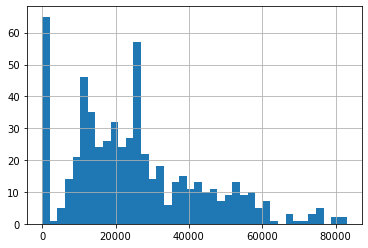

In [102]:
df['Attendance'].hist(bins=40);

Ого! Надо будет не забыть подумать, откуда такое количество в левом столбце...

Что за грубияны с тринадцатью красными карточками за сезон?!


In [103]:
df[df['Performance: CrdR'] == 13]

,Rk,Squad,MP,W (per game),D (per game),L (per game),GA (per game),GD (per game),Pts/MP,xGA (per game),...,Performance: PKwon,Performance: PKcon,Performance: OG,Performance: Recov (per game),Aerial Duels: Won (per game),Aerial Duels: Won%,Int (per game),Tkl+Int (per game),Clr (per game),Err (per game)
125,6,Betis,33,0.45,0.21,0.33,1.12,0.09,1.58,1.36,...,4,3,1,49.97,12.09,48.4,9.61,26.94,22.64,0.18


При этом они заняли шестое место...

А еще кто-то выигрывал всего 5% игр за сезон! Кто же это?

In [104]:
df[df['W (per game)'] == 0.05] # неудивительно, что они вылетели (заняли 20 место и перешли в лигу ниже)... 

,Rk,Squad,MP,W (per game),D (per game),L (per game),GA (per game),GD (per game),Pts/MP,xGA (per game),...,Performance: PKwon,Performance: PKcon,Performance: OG,Performance: Recov (per game),Aerial Duels: Won (per game),Aerial Duels: Won%,Int (per game),Tkl+Int (per game),Clr (per game),Err (per game)
567,20,Chievo,38,0.05,0.37,0.58,1.97,-1.32,0.45,1.59,...,3,4,2,51.16,18.29,48.7,12.39,28.79,26.0,0.47


In [105]:
round(df.iloc[:, 20:40].describe(), 2)

,Progression: PrgP,Per 90 Minutes: Gls,Per 90 Minutes: Ast,Per 90 Minutes: G+A,Per 90 Minutes: G-PK,Per 90 Minutes: G+A-PK,Per 90 Minutes: xG,Per 90 Minutes: xAG,Per 90 Minutes: xG+xAG,Per 90 Minutes: npxG,Per 90 Minutes: npxG+xAG,Performance: Saves (per game),Performance: Save%,Performance: CS%,Penalty Kicks: PKatt,Penalty Kicks: PKA,Penalty Kicks: PKsv,Penalty Kicks: PKm,Penalty Kicks: Save%,Standard: SoT%
count,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00
mean,38.47,1.34,0.93,2.28,1.22,2.15,1.35,0.95,2.30,1.22,2.17,2.88,70.53,26.79,5.98,4.69,0.96,0.33,16.95,33.04
std,8.44,0.45,0.35,0.79,0.43,0.77,0.34,0.27,0.60,0.32,0.58,0.57,4.84,10.39,2.72,2.40,0.99,0.58,17.86,3.36
min,22.21,0.50,0.33,0.84,0.42,0.76,0.76,0.51,1.28,0.67,1.18,1.26,52.20,2.90,0.00,0.00,0.00,0.00,0.00,25.10
25%,32.62,1.03,0.68,1.71,0.92,1.61,1.10,0.76,1.87,0.98,1.75,2.47,67.28,19.25,4.00,3.00,0.00,0.00,0.00,30.80
50%,36.95,1.26,0.87,2.13,1.15,2.00,1.28,0.89,2.18,1.15,2.04,2.84,70.55,26.30,6.00,4.00,1.00,0.00,14.30,32.90
75%,42.86,1.58,1.12,2.68,1.44,2.56,1.50,1.09,2.58,1.37,2.45,3.26,73.80,32.40,8.00,6.00,1.00,1.00,25.00,35.22
max,68.62,2.88,2.24,5.09,2.68,4.88,2.75,2.15,4.78,2.51,4.64,4.76,88.00,75.80,16.00,15.00,5.00,3.00,100.00,45.90


Посмотрим на команды с худшим (52,2% отраженных ударов) и лучшим (88% отраженных ударов) вратарем.

In [106]:
df[df['Performance: Save%'] == 52.2] # кошмар...

,Rk,Squad,MP,W (per game),D (per game),L (per game),GA (per game),GD (per game),Pts/MP,xGA (per game),...,Performance: PKwon,Performance: PKcon,Performance: OG,Performance: Recov (per game),Aerial Duels: Won (per game),Aerial Duels: Won%,Int (per game),Tkl+Int (per game),Clr (per game),Err (per game)
19,20,Southampton,36,0.17,0.17,0.67,1.83,-0.97,0.67,1.52,...,3,3,5,56.75,14.89,47.7,11.03,29.78,22.19,0.19


In [107]:
df[df['Performance: Save%'] == 88] # круто!

,Rk,Squad,MP,W (per game),D (per game),L (per game),GA (per game),GD (per game),Pts/MP,xGA (per game),...,Performance: PKwon,Performance: PKcon,Performance: OG,Performance: Recov (per game),Aerial Duels: Won (per game),Aerial Duels: Won%,Int (per game),Tkl+Int (per game),Clr (per game),Err (per game)
120,1,Barcelona,33,0.79,0.12,0.09,0.33,1.48,2.48,0.77,...,0,2,2,53.18,12.39,56.6,6.94,20.91,12.15,0.39


Получается, что оба наблюдения были зафиксированы в этом сезоне. Интересно!

In [108]:
round(df.iloc[:, 40:60].describe(), 2)

,Standard: Sh/90,Standard: SoT/90,Standard: G/Sh,Standard: G/SoT,Standard: Dist,Standard: FK,Standard: PK,Standard: PKatt,Expected: npxG/Sh,Expected: G-xG,Expected: np:G-xG,Total: Cmp (per game),Total: Att (per game),Total: Cmp%,Total: TotDist (per game),Total: PrgDist (per game),Short: Cmp (per game),Short: Att (per game),Short: Cmp%,Medium: Cmp (per game)
count,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00
mean,12.32,4.09,0.10,0.29,18.04,0.49,4.69,5.98,0.10,-0.09,-0.16,387.04,493.41,77.70,6924.46,2554.12,173.13,198.12,86.74,157.80
std,2.14,0.96,0.02,0.05,1.06,0.19,2.49,2.92,0.01,7.21,7.14,89.70,84.72,4.86,1353.61,300.13,48.49,48.72,3.13,38.15
min,6.97,2.26,0.04,0.15,15.10,0.09,0.00,0.00,0.06,-18.30,-16.60,188.68,308.29,60.70,3644.74,1761.61,82.71,107.66,75.00,66.84
25%,10.84,3.42,0.08,0.26,17.30,0.37,3.00,4.00,0.09,-5.30,-5.03,326.26,434.92,74.60,5968.89,2346.00,137.88,162.21,84.70,129.94
50%,11.96,3.89,0.10,0.29,18.00,0.46,4.00,6.00,0.10,-0.60,-0.90,367.30,473.86,77.75,6719.60,2506.62,161.35,186.46,86.90,152.28
75%,13.44,4.61,0.11,0.33,18.80,0.58,6.00,8.00,0.11,4.40,4.10,433.46,539.47,81.00,7618.81,2748.90,196.75,221.42,88.90,181.74
max,19.65,7.56,0.19,0.45,20.90,1.58,15.00,20.00,0.16,26.70,28.60,688.53,788.45,89.40,11706.15,3881.15,371.97,401.97,93.50,290.59


Столбец "Expected: G-xG" показывает разницу между количеством забитых голов и количеством ожидаемых. Посмотрим на самую невезучую команду...

In [109]:
df[df['Expected: G-xG'] == -18.3] # а вот и самые невезучие команды за 6 сезонов в ведущих европейских лигах!

,Rk,Squad,MP,W (per game),D (per game),L (per game),GA (per game),GD (per game),Pts/MP,xGA (per game),...,Performance: PKwon,Performance: PKcon,Performance: OG,Performance: Recov (per game),Aerial Duels: Won (per game),Aerial Duels: Won%,Int (per game),Tkl+Int (per game),Clr (per game),Err (per game)
326,7,Nice,38,0.39,0.29,0.32,0.92,-0.13,1.47,1.32,...,7,6,1,51.50,13.58,50.7,11.84,29.26,20.45,0.29
578,11,Sassuolo,38,0.29,0.26,0.45,1.55,-0.79,1.13,1.29,...,6,3,2,54.66,15.58,52.9,13.32,28.26,28.55,0.42


In [110]:
df[df['Expected: G-xG'] == 26.7] # вот это им везло, однако!

,Rk,Squad,MP,W (per game),D (per game),L (per game),GA (per game),GD (per game),Pts/MP,xGA (per game),...,Performance: PKwon,Performance: PKcon,Performance: OG,Performance: Recov (per game),Aerial Duels: Won (per game),Aerial Duels: Won%,Int (per game),Tkl+Int (per game),Clr (per game),Err (per game)
568,1,Juventus,38,0.79,0.13,0.08,0.63,1.63,2.5,0.72,...,5,4,2,52.71,11.97,55.4,11.08,24.68,19.66,0.45


In [111]:
round(df.iloc[:, 60:80].describe(), 2) 

,Medium: Att (per game),Medium: Cmp%,Long: Cmp (per game),Long: Att (per game),Long: Cmp%,Unnamed: 21_level_0: KP,Unnamed: 22_level_0: 1/3,Unnamed: 23_level_0: PPA,Unnamed: 24_level_0: CrsPA,Pass Types: Live (per game),Pass Types: Dead (per game),Pass Types: FK (per game),Pass Types: TB (per game),Pass Types: Sw (per game),Pass Types: Crs (per game),Pass Types: TI (per game),Pass Types: CK (per game),Corner Kicks: In (per game),Corner Kicks: Out (per game),Corner Kicks: Str (per game)
count,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00
mean,186.39,83.98,43.87,79.42,55.27,335.00,1073.84,274.87,75.02,442.07,49.45,13.52,1.07,4.18,18.08,20.89,4.91,2.02,1.91,0.08
std,37.38,3.96,6.81,8.43,6.39,69.75,266.02,79.50,20.83,85.92,3.03,1.73,0.68,1.44,2.75,2.21,0.87,0.65,0.69,0.14
min,95.32,67.50,27.67,54.91,38.80,161.00,542.00,112.00,30.00,258.50,40.51,8.13,0.13,1.24,10.37,14.26,3.08,0.24,0.03,0.00
25%,159.20,81.47,39.12,73.68,50.90,285.00,885.00,220.75,60.00,383.36,47.47,12.32,0.61,3.18,16.13,19.32,4.32,1.61,1.45,0.00
50%,181.09,84.40,43.43,78.53,54.80,326.00,1015.50,256.00,73.00,421.21,49.71,13.58,0.91,4.03,17.96,20.95,4.82,1.95,1.84,0.03
75%,209.41,86.82,47.63,84.82,59.00,369.25,1193.50,316.50,87.00,487.79,51.56,14.77,1.34,5.01,19.75,22.32,5.38,2.42,2.29,0.09
max,324.00,92.60,77.91,117.74,74.20,582.00,2110.00,554.00,164.00,741.53,58.97,19.68,5.68,11.71,28.74,28.79,8.44,4.16,5.45,1.79


In [112]:
round(df.iloc[:, 80:100].describe(), 2)

,Outcomes: Blocks (per game),SCA: SCA90,SCA Types: PassLive (per game),SCA Types: PassDead (per game),SCA Types: TO (per game),SCA Types: Sh (per game),SCA Types: Fld (per game),SCA Types: Def (per game),GCA: GCA90,GCA Types: PassLive (per game),GCA Types: PassDead (per game),GCA Types: TO (per game),GCA Types: Sh (per game),GCA Types: Fld (per game),GCA Types: Def (per game),Tackles: Tkl (per game),Tackles: TklW (per game),Tackles: Def 3rd (per game),Tackles: Mid 3rd (per game),Tackles: Att 3rd (per game)
count,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00
mean,9.24,21.79,15.64,1.98,1.32,1.28,1.21,0.36,2.32,0.68,0.07,0.07,0.09,0.08,0.02,16.41,9.99,7.94,6.52,1.95
std,1.21,4.06,3.46,0.40,0.40,0.35,0.28,0.12,0.81,0.07,0.03,0.03,0.04,0.03,0.02,1.88,1.58,1.25,0.97,0.42
min,6.03,12.11,8.37,1.00,0.37,0.43,0.58,0.11,0.71,0.48,0.00,0.00,0.00,0.00,0.00,12.00,6.63,4.79,4.29,0.89
25%,8.34,18.91,13.11,1.70,1.05,1.05,1.00,0.26,1.71,0.64,0.05,0.05,0.07,0.05,0.00,15.04,8.85,7.08,5.83,1.66
50%,9.11,21.06,15.02,1.97,1.26,1.24,1.21,0.35,2.16,0.68,0.07,0.07,0.08,0.07,0.01,16.34,9.80,7.92,6.46,1.91
75%,9.97,23.87,17.46,2.26,1.58,1.47,1.39,0.45,2.74,0.72,0.09,0.09,0.11,0.10,0.02,17.62,10.88,8.79,7.11,2.21
max,14.26,35.68,27.50,3.17,2.82,2.74,2.26,0.79,5.18,0.84,0.18,0.19,0.21,0.20,0.08,24.13,16.16,11.63,9.79,3.56


Кто-то совершал более 24 отборов в среднем за игру. При среднем показателе в 16,4 это довольно много. По идее, это должна быть команда из нижней части таблицы, потому что они чаще обороняются и им приходится много отбирать мячи. Давайте проверим!

In [113]:
df[df['Tackles: Tkl (per game)'] == 24.13] # бойцы! кстати, Атлетико славится своей неуступчивостью.

,Rk,Squad,MP,W (per game),D (per game),L (per game),GA (per game),GD (per game),Pts/MP,xGA (per game),...,Performance: PKwon,Performance: PKcon,Performance: OG,Performance: Recov (per game),Aerial Duels: Won (per game),Aerial Duels: Won%,Int (per game),Tkl+Int (per game),Clr (per game),Err (per game)
221,2,Atlético Madrid,38,0.61,0.26,0.13,0.58,0.95,2.08,0.94,...,4,4,1,58.26,14.58,50.7,13.5,37.63,23.29,0.11


Не... Команда заняла второе место. Но это Атлетико, так что ничего удивительного.

In [114]:
round(df.iloc[:, 100:120].describe(), 2)

,Challenges: Tkl (per game),Challenges: Att (per game),Challenges: Tkl%,Challenges: Lost (per game),Blocks: Blocks (per game),Blocks: Sh (per game),Blocks: Pass (per game),Touches: Touches (per game),Touches: Def Pen (per game),Touches: Def 3rd (per game),Touches: Mid 3rd (per game),Touches: Att 3rd (per game),Touches: Att Pen (per game),Take-Ons: Att (per game),Take-Ons: Succ%,Take-Ons: Tkld (per game),Take-Ons: Tkld%,Carries: Carries (per game),Carries: TotDist (per game),Carries: PrgDist (per game)
count,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00
mean,6.99,16.16,43.25,9.17,10.71,3.06,7.65,602.65,60.46,189.01,279.29,140.44,20.14,16.53,55.55,6.99,42.40,338.34,1819.03,937.43
std,1.16,1.95,4.92,1.37,1.34,0.70,1.13,82.06,6.94,19.29,50.82,30.35,4.88,2.91,6.64,1.37,4.78,76.28,393.24,225.67
min,4.08,9.62,31.20,4.41,6.92,1.39,4.89,420.50,39.05,123.39,172.21,91.71,10.84,9.08,37.70,3.34,28.40,163.71,1036.97,497.53
25%,6.16,14.84,39.78,8.23,9.76,2.58,6.87,546.83,55.34,175.02,242.55,119.08,16.61,14.54,51.90,6.04,39.38,281.64,1538.83,775.58
50%,6.89,16.07,42.80,9.11,10.66,3.00,7.47,584.30,60.24,188.78,269.93,132.93,19.03,16.25,56.45,6.91,42.40,327.44,1758.32,908.86
75%,7.68,17.39,46.30,10.03,11.61,3.50,8.32,646.99,65.59,202.04,304.92,153.62,22.76,18.32,60.30,7.80,45.40,377.63,2046.09,1073.63
max,10.74,23.32,60.80,13.74,14.76,5.84,11.68,884.95,82.56,249.81,488.55,262.24,39.45,26.25,71.50,12.47,60.50,645.77,3365.40,1794.66


Какая-то команда боится мяча как огня! Они несли его в ногах чуть больше чем на километр в среднем на игру, что почти в два раза меньше, чем в среднем по всем наблюдениям. Кто же это был?

In [115]:
df[df['Carries: TotDist (per game)'] == 1036.97] # совсем не жаль, что они вылетели  

,Rk,Squad,MP,W (per game),D (per game),L (per game),GA (per game),GD (per game),Pts/MP,xGA (per game),...,Performance: PKwon,Performance: PKcon,Performance: OG,Performance: Recov (per game),Aerial Duels: Won (per game),Aerial Duels: Won%,Int (per game),Tkl+Int (per game),Clr (per game),Err (per game)
97,18,Cardiff City,38,0.26,0.11,0.63,1.82,-0.92,0.89,1.62,...,2,7,0,51.97,25.42,50.0,13.92,31.16,27.21,0.47


In [116]:
round(df.iloc[:, 120:].describe(), 2)

,Carries: 1/3 (per game),Carries: CPA (per game),Receiving: Rec (per game),Receiving: PrgR (per game),Performance: 2CrdY,Performance: Fls (per game),Performance: Fld (per game),Performance: Off (per game),Performance: PKwon,Performance: PKcon,Performance: OG,Performance: Recov (per game),Aerial Duels: Won (per game),Aerial Duels: Won%,Int (per game),Tkl+Int (per game),Clr (per game),Err (per game)
count,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00
mean,13.36,4.20,383.98,38.11,1.60,12.46,11.81,1.88,4.48,5.98,1.53,53.24,15.97,50.11,10.67,27.08,20.05,0.34
std,3.31,1.43,89.42,8.42,1.37,1.75,1.59,0.44,2.48,2.72,1.21,3.94,3.50,3.20,1.63,2.91,4.15,0.13
min,6.59,1.68,186.26,21.74,0.00,8.29,7.26,0.79,0.00,0.00,0.00,38.00,6.63,41.10,6.00,18.65,10.03,0.03
25%,10.96,3.11,323.90,32.24,1.00,11.20,10.70,1.56,3.00,4.00,1.00,50.79,13.43,47.80,9.54,24.91,17.47,0.24
50%,12.92,3.97,364.60,36.58,1.00,12.50,11.96,1.87,4.00,6.00,1.00,53.18,15.86,50.10,10.71,27.04,20.00,0.32
75%,14.92,5.06,429.92,42.50,2.00,13.58,12.88,2.18,6.00,8.00,2.00,55.61,18.09,52.20,11.74,28.98,22.58,0.44
max,26.76,10.16,684.82,68.06,6.00,18.58,17.50,3.61,15.00,16.00,6.00,66.21,26.74,58.60,15.34,37.63,34.42,0.87


Вау! Кто-то умудрился забить 6 автоголов за сезон!

In [117]:
df[df['Performance: OG'] == 6] # неудачники...

,Rk,Squad,MP,W (per game),D (per game),L (per game),GA (per game),GD (per game),Pts/MP,xGA (per game),...,Performance: PKwon,Performance: PKcon,Performance: OG,Performance: Recov (per game),Aerial Duels: Won (per game),Aerial Duels: Won%,Int (per game),Tkl+Int (per game),Clr (per game),Err (per game)
501,14,Empoli,38,0.26,0.29,0.45,1.84,-0.53,1.08,1.74,...,6,10,6,52.58,11.24,43.8,9.26,24.21,20.32,0.26
525,18,Benevento,38,0.18,0.32,0.50,1.97,-0.92,0.87,1.69,...,7,5,6,46.03,13.05,44.6,10.08,23.53,19.63,0.34


In [121]:
df.columns.to_list()

['Rk',
 'Squad',
 'MP',
 'W (per game)',
 'D (per game)',
 'L (per game)',
 'GA (per game)',
 'GD (per game)',
 'Pts/MP',
 'xGA (per game)',
 'xGD/90',
 'Attendance',
 'Top Team Scorer (per game)',
 'Pl',
 'Age',
 'Poss',
 'Performance: PKatt',
 'Performance: CrdY (per game)',
 'Performance: CrdR',
 'Progression: PrgC (per game)',
 'Progression: PrgP',
 'Per 90 Minutes: Gls',
 'Per 90 Minutes: Ast',
 'Per 90 Minutes: G+A',
 'Per 90 Minutes: G-PK',
 'Per 90 Minutes: G+A-PK',
 'Per 90 Minutes: xG',
 'Per 90 Minutes: xAG',
 'Per 90 Minutes: xG+xAG',
 'Per 90 Minutes: npxG',
 'Per 90 Minutes: npxG+xAG',
 'Performance: Saves (per game)',
 'Performance: Save%',
 'Performance: CS%',
 'Penalty Kicks: PKatt',
 'Penalty Kicks: PKA',
 'Penalty Kicks: PKsv',
 'Penalty Kicks: PKm',
 'Penalty Kicks: Save%',
 'Standard: SoT%',
 'Standard: Sh/90',
 'Standard: SoT/90',
 'Standard: G/Sh',
 'Standard: G/SoT',
 'Standard: Dist',
 'Standard: FK',
 'Standard: PK',
 'Standard: PKatt',
 'Expected: npxG/Sh',
 

## Визуализэйшн

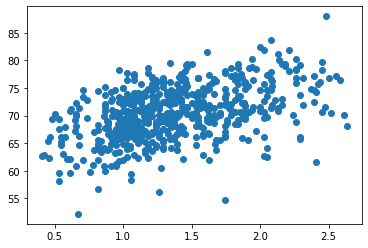

In [122]:
import matplotlib.pyplot as plt

plt.scatter(df['Per 90 Minutes: Gls'], df['Performance: Save%']);

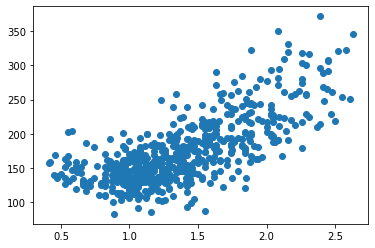

In [123]:
plt.scatter(df['Pts/MP'], df['Short: Cmp (per game)']);

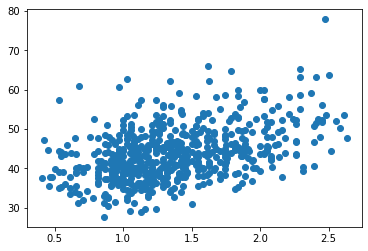

In [126]:
plt.scatter(df['Pts/MP'], df['Long: Cmp (per game)']);

In [127]:
df[df['Long: Cmp (per game)'] == df['Long: Cmp (per game)'].max()]

,Rk,Squad,MP,W (per game),D (per game),L (per game),GA (per game),GD (per game),Pts/MP,xGA (per game),...,Performance: PKwon,Performance: PKcon,Performance: OG,Performance: Recov (per game),Aerial Duels: Won (per game),Aerial Duels: Won%,Int (per game),Tkl+Int (per game),Clr (per game),Err (per game)
450,1,Bayern Munich,34,0.79,0.09,0.12,0.82,1.88,2.47,0.93,...,7,4,3,49.62,15.24,53.6,10.44,28.35,11.74,0.32


In [132]:
df[df['Squad'] == 'West Ham']['Per 90 Minutes: xG']

14     1.30
26     1.35
45     1.46
75     1.28
89     1.25
112    0.97
Name: Per 90 Minutes: xG, dtype: float64